In [1]:
import tensorflow as tf
import yfinance as yf
from yahoo_fin.stock_info import get_data
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
# Imports 3 years of BTC daily data from yahoo finance
ADA_df = get_data("ADA-USD", start_date="6/30/2019", end_date="06/30/2022", index_as_date = True, interval="1d")
df = ADA_df.iloc[:,0:-1]
df.head()

,open,high,low,close,adjclose,volume
2019-06-30,0.090486,0.091168,0.082098,0.082098,0.082098,161855807
2019-07-01,0.082098,0.085895,0.080504,0.083822,0.083822,168654991
2019-07-02,0.083800,0.084598,0.076777,0.081077,0.081077,180980795
2019-07-03,0.081033,0.083792,0.080197,0.082998,0.082998,154492407
2019-07-04,0.083007,0.083007,0.077588,0.077774,0.077774,142713205


In [3]:
# Defines function to split X and y data
def window_data(df, window, feature_col_number, target_col_number):
    # Creates empty X and y list
    X = []
    y = []
    # loops through btc data
    for i in range(len(df) - window - 1):
        # splits the features by grouping window amount of previous close data
        features = df.iloc[i:(i + window), feature_col_number]
        # splits target by taking current close values
        target = df.iloc[(i + window), target_col_number]
        # Adds end of each loops data to respective X and y list
        X.append(features)
        y.append(target)
    # returns X,y as arrays
    return np.array(X), np.array(y).reshape(-1, 1)

In [4]:
# Defines window size
window_size=10

In [5]:
# Runs function to split X and y data
X, y=window_data(df, window_size, 3, 3)
# Displays X and y
display(X)
display(y)

array([[0.082098  , 0.083822  , 0.081077  , ..., 0.079964  , 0.080476  ,
        0.077993  ],
       [0.083822  , 0.081077  , 0.082998  , ..., 0.080476  , 0.077993  ,
        0.07194   ],
       [0.081077  , 0.082998  , 0.077774  , ..., 0.077993  , 0.07194   ,
        0.065199  ],
       ...,
       [0.48739201, 0.456182  , 0.484364  , ..., 0.49922401, 0.49894601,
        0.48965299],
       [0.456182  , 0.484364  , 0.49226099, ..., 0.49894601, 0.48965299,
        0.48579001],
       [0.484364  , 0.49226099, 0.479204  , ..., 0.48965299, 0.48579001,
        0.46967101]])

array([[0.07194   ],
       [0.065199  ],
       [0.069754  ],
       ...,
       [0.48579001],
       [0.46967101],
       [0.465509  ]])

In [6]:
# Scales X and y data using MinMaxScaler
X_scaler=MinMaxScaler()
X_scaler.fit(X)
X_scaled=X_scaler.transform(X)
y_scaler=MinMaxScaler()
y_scaler.fit(y)
y_scaled=y_scaler.transform(y)

In [7]:
# Defines where train and test data will be split (70% is train)
split=int(0.7*len(X_scaled))
# Splits train and test data
X_train=X_scaled[:split]
X_test=X_scaled[split:]
y_train=y_scaled[:split]
y_test=y_scaled[split:]

In [8]:
#X_scaled=X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
#display(X.shape)

In [9]:
# Reshapes data into size LSTM can handle
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
display(X_train.shape)
display(X_test.shape)

(760, 10, 1)

(326, 10, 1)

In [10]:
# Creates neural network
model=Sequential()
# Defines and adds LSTM layer
first_lstm_layer=LSTM(units=30, return_sequences=True, input_shape=(window_size, 1))
model.add(first_lstm_layer)
# Randomly drops 20% of defined nodes
first_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model.add(first_dropout_layer)
second_lstm_layer=LSTM(units=30, return_sequences=True)
model.add(second_lstm_layer)
# Randomly drops 20% of defined nodes
second_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model.add(second_dropout_layer)
third_lstm_layer=LSTM(units=30)
model.add(third_lstm_layer)
# Defines and adds output layer with linear activation
output_layer=Dense(units=1, activation='linear')
model.add(output_layer)

2022-07-11 22:57:26.258168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Compiles model
model.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')

In [13]:
# Provides summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 30)            3840      
                                                                 
 dropout (Dropout)           (None, 10, 30)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 30)            7320      
                                                                 
 dropout_1 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-traina

In [14]:
# Initially fits model using training data
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
24/24 [==============================] - 4s 11ms/step - loss: 0.0183 - mean_squared_error: 0.0183
Epoch 2/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 3/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 4/50
24/24 [==============================] - 0s 11ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 5/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 6/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 7/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 8/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 9/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 10/50
24/24 [==

In [15]:
# Projects future data by using model to predict next close and then uses that value to retrain 
# the model before making next prediction
for i in range(326): 
    # predicts next close value and reshapes it
    prediction_scaled=model.predict(X_train[-1].reshape(1, window_size, 1))
    # transforms prediction back to original scale
    next_prediction=y_scaler.inverse_transform(prediction_scaled)
    # displays predicted close value
    display(next_prediction)
    # adds predicted close value to list
    new_train_sample=np.append(X_train[-1], prediction_scaled)[1:].reshape(1, window_size, 1)
    # adds new list entry of predicted close to X train
    X_train=np.append(X_train, new_train_sample, axis=0)
    # adds new list entry of predicted close to y train
    y_train=np.append(y_train, prediction_scaled, axis=0)
    # refits model with new close value
    model.fit(X_train, y_train, epochs=5)

1/1 [==============================] - 1s 803ms/step


array([[1.2925047]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 10ms/step - loss: 8.3259e-04 - mean_squared_error: 8.3259e-04
Epoch 2/5
24/24 [==============================] - 0s 8ms/step - loss: 7.9348e-04 - mean_squared_error: 7.9348e-04
Epoch 3/5
24/24 [==============================] - 0s 9ms/step - loss: 8.1206e-04 - mean_squared_error: 8.1206e-04
Epoch 4/5
24/24 [==============================] - 0s 12ms/step - loss: 8.3029e-04 - mean_squared_error: 8.3029e-04
Epoch 5/5
1/1 [==============================] - 0s 15ms/step


array([[1.3851012]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 9ms/step - loss: 7.4404e-04 - mean_squared_error: 7.4404e-04
Epoch 2/5
24/24 [==============================] - 0s 10ms/step - loss: 8.2457e-04 - mean_squared_error: 8.2457e-04
Epoch 3/5
24/24 [==============================] - 0s 10ms/step - loss: 8.0719e-04 - mean_squared_error: 8.0719e-04
Epoch 4/5
24/24 [==============================] - 0s 10ms/step - loss: 7.8168e-04 - mean_squared_error: 7.8168e-04
Epoch 5/5
1/1 [==============================] - 0s 15ms/step


array([[1.3483042]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 9ms/step - loss: 7.7179e-04 - mean_squared_error: 7.7179e-04
Epoch 2/5
24/24 [==============================] - 0s 9ms/step - loss: 8.1329e-04 - mean_squared_error: 8.1329e-04
Epoch 3/5
24/24 [==============================] - 0s 14ms/step - loss: 7.6493e-04 - mean_squared_error: 7.6493e-04
Epoch 4/5
24/24 [==============================] - 0s 9ms/step - loss: 7.0776e-04 - mean_squared_error: 7.0776e-04
Epoch 5/5
1/1 [==============================] - 0s 16ms/step


array([[1.3786455]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 9ms/step - loss: 7.1377e-04 - mean_squared_error: 7.1377e-04
Epoch 2/5
24/24 [==============================] - 0s 11ms/step - loss: 7.7469e-04 - mean_squared_error: 7.7469e-04
Epoch 3/5
24/24 [==============================] - 0s 11ms/step - loss: 7.5630e-04 - mean_squared_error: 7.5630e-04
Epoch 4/5
24/24 [==============================] - 0s 9ms/step - loss: 7.3504e-04 - mean_squared_error: 7.3504e-04
Epoch 5/5
1/1 [==============================] - 0s 16ms/step


array([[1.4291129]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 9ms/step - loss: 6.8282e-04 - mean_squared_error: 6.8282e-04
Epoch 2/5
24/24 [==============================] - 0s 9ms/step - loss: 7.0025e-04 - mean_squared_error: 7.0025e-04
Epoch 3/5
24/24 [==============================] - 0s 9ms/step - loss: 7.3288e-04 - mean_squared_error: 7.3288e-04
Epoch 4/5
24/24 [==============================] - 0s 9ms/step - loss: 7.7155e-04 - mean_squared_error: 7.7155e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3813446]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 9ms/step - loss: 6.1694e-04 - mean_squared_error: 6.1694e-04
Epoch 2/5
24/24 [==============================] - 0s 10ms/step - loss: 7.3430e-04 - mean_squared_error: 7.3430e-04
Epoch 3/5
24/24 [==============================] - 0s 10ms/step - loss: 7.4019e-04 - mean_squared_error: 7.4019e-04
Epoch 4/5
24/24 [==============================] - 0s 10ms/step - loss: 7.5243e-04 - mean_squared_error: 7.5243e-04
Epoch 5/5
1/1 [==============================] - 0s 15ms/step


array([[1.4531058]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 10ms/step - loss: 6.7691e-04 - mean_squared_error: 6.7691e-04
Epoch 2/5
24/24 [==============================] - 0s 10ms/step - loss: 7.3558e-04 - mean_squared_error: 7.3558e-04
Epoch 3/5
24/24 [==============================] - 0s 10ms/step - loss: 7.7815e-04 - mean_squared_error: 7.7815e-04
Epoch 4/5
24/24 [==============================] - 0s 10ms/step - loss: 6.7196e-04 - mean_squared_error: 6.7196e-04
Epoch 5/5
1/1 [==============================] - 0s 18ms/step


array([[1.3850967]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 10ms/step - loss: 6.7032e-04 - mean_squared_error: 6.7032e-04
Epoch 2/5
24/24 [==============================] - 0s 11ms/step - loss: 6.6248e-04 - mean_squared_error: 6.6248e-04
Epoch 3/5
24/24 [==============================] - 0s 10ms/step - loss: 7.9613e-04 - mean_squared_error: 7.9613e-04
Epoch 4/5
24/24 [==============================] - 0s 10ms/step - loss: 6.9692e-04 - mean_squared_error: 6.9692e-04
Epoch 5/5
1/1 [==============================] - 0s 17ms/step


array([[1.419856]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 10ms/step - loss: 7.1472e-04 - mean_squared_error: 7.1472e-04
Epoch 2/5
25/25 [==============================] - 0s 10ms/step - loss: 6.0663e-04 - mean_squared_error: 6.0663e-04
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 6.4473e-04 - mean_squared_error: 6.4473e-04
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 7.3509e-04 - mean_squared_error: 7.3509e-04
Epoch 5/5
1/1 [==============================] - 0s 18ms/step


array([[1.4477766]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 10ms/step - loss: 5.9761e-04 - mean_squared_error: 5.9761e-04
Epoch 2/5
25/25 [==============================] - 0s 10ms/step - loss: 6.5097e-04 - mean_squared_error: 6.5097e-04
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 5.8689e-04 - mean_squared_error: 5.8689e-04
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 6.0527e-04 - mean_squared_error: 6.0527e-04
Epoch 5/5
1/1 [==============================] - 0s 17ms/step


array([[1.478858]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 10ms/step - loss: 6.3334e-04 - mean_squared_error: 6.3334e-04
Epoch 2/5
25/25 [==============================] - 0s 10ms/step - loss: 6.1499e-04 - mean_squared_error: 6.1499e-04
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 6.8973e-04 - mean_squared_error: 6.8973e-04
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 6.2232e-04 - mean_squared_error: 6.2232e-04
Epoch 5/5
1/1 [==============================] - 0s 17ms/step


array([[1.4493958]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 10ms/step - loss: 5.3332e-04 - mean_squared_error: 5.3332e-04
Epoch 2/5
25/25 [==============================] - 0s 12ms/step - loss: 5.0579e-04 - mean_squared_error: 5.0579e-04
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 5.6502e-04 - mean_squared_error: 5.6502e-04
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 6.0553e-04 - mean_squared_error: 6.0553e-04
Epoch 5/5
1/1 [==============================] - 0s 18ms/step


array([[1.4514464]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 10ms/step - loss: 5.9562e-04 - mean_squared_error: 5.9562e-04
Epoch 2/5
25/25 [==============================] - 0s 10ms/step - loss: 5.5743e-04 - mean_squared_error: 5.5743e-04
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 5.7688e-04 - mean_squared_error: 5.7688e-04
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 5.5610e-04 - mean_squared_error: 5.5610e-04
Epoch 5/5
1/1 [==============================] - 0s 17ms/step


array([[1.4301027]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 10ms/step - loss: 5.1590e-04 - mean_squared_error: 5.1590e-04
Epoch 2/5
25/25 [==============================] - 0s 11ms/step - loss: 5.0045e-04 - mean_squared_error: 5.0045e-04
Epoch 3/5
25/25 [==============================] - 0s 13ms/step - loss: 6.3631e-04 - mean_squared_error: 6.3631e-04
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 5.0276e-04 - mean_squared_error: 5.0276e-04
Epoch 5/5
1/1 [==============================] - 0s 16ms/step


array([[1.469844]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 8ms/step - loss: 6.5067e-04 - mean_squared_error: 6.5067e-04
Epoch 2/5
25/25 [==============================] - 0s 9ms/step - loss: 4.7365e-04 - mean_squared_error: 4.7365e-04
Epoch 3/5
25/25 [==============================] - 0s 8ms/step - loss: 5.8549e-04 - mean_squared_error: 5.8549e-04
Epoch 4/5
25/25 [==============================] - 0s 8ms/step - loss: 6.3308e-04 - mean_squared_error: 6.3308e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3893651]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 8ms/step - loss: 5.9441e-04 - mean_squared_error: 5.9441e-04
Epoch 2/5
25/25 [==============================] - 0s 8ms/step - loss: 5.8913e-04 - mean_squared_error: 5.8913e-04
Epoch 3/5
25/25 [==============================] - 0s 8ms/step - loss: 6.0347e-04 - mean_squared_error: 6.0347e-04
Epoch 4/5
25/25 [==============================] - 0s 9ms/step - loss: 4.9864e-04 - mean_squared_error: 4.9864e-04
Epoch 5/5
1/1 [==============================] - 0s 17ms/step


array([[1.4385533]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 9ms/step - loss: 5.4691e-04 - mean_squared_error: 5.4691e-04
Epoch 2/5
25/25 [==============================] - 0s 8ms/step - loss: 4.8052e-04 - mean_squared_error: 4.8052e-04
Epoch 3/5
25/25 [==============================] - 0s 9ms/step - loss: 4.8708e-04 - mean_squared_error: 4.8708e-04
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 4.7455e-04 - mean_squared_error: 4.7455e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.374611]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 10ms/step - loss: 4.9311e-04 - mean_squared_error: 4.9311e-04
Epoch 2/5
25/25 [==============================] - 0s 10ms/step - loss: 5.1615e-04 - mean_squared_error: 5.1615e-04
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 4.8066e-04 - mean_squared_error: 4.8066e-04
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 4.8252e-04 - mean_squared_error: 4.8252e-04
Epoch 5/5
1/1 [==============================] - 0s 16ms/step


array([[1.416325]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 11ms/step - loss: 5.0409e-04 - mean_squared_error: 5.0409e-04
Epoch 2/5
25/25 [==============================] - 0s 10ms/step - loss: 6.3117e-04 - mean_squared_error: 6.3117e-04
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 5.6062e-04 - mean_squared_error: 5.6062e-04
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 4.8568e-04 - mean_squared_error: 4.8568e-04
Epoch 5/5
1/1 [==============================] - 0s 18ms/step


array([[1.4400508]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 10ms/step - loss: 4.6142e-04 - mean_squared_error: 4.6142e-04
Epoch 2/5
25/25 [==============================] - 0s 10ms/step - loss: 4.7667e-04 - mean_squared_error: 4.7667e-04
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 4.7347e-04 - mean_squared_error: 4.7347e-04
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 5.1115e-04 - mean_squared_error: 5.1115e-04
Epoch 5/5
1/1 [==============================] - 0s 15ms/step


array([[1.445455]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 10ms/step - loss: 4.6336e-04 - mean_squared_error: 4.6336e-04
Epoch 2/5
25/25 [==============================] - 0s 10ms/step - loss: 4.5597e-04 - mean_squared_error: 4.5597e-04
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 4.8511e-04 - mean_squared_error: 4.8511e-04
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 5.0122e-04 - mean_squared_error: 5.0122e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4401361]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 10ms/step - loss: 4.9117e-04 - mean_squared_error: 4.9117e-04
Epoch 2/5
25/25 [==============================] - 0s 10ms/step - loss: 5.4998e-04 - mean_squared_error: 5.4998e-04
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 7.0036e-04 - mean_squared_error: 7.0036e-04
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 5.9074e-04 - mean_squared_error: 5.9074e-04
Epoch 5/5
1/1 [==============================] - 0s 17ms/step


array([[1.4816997]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 10ms/step - loss: 4.4513e-04 - mean_squared_error: 4.4513e-04
Epoch 2/5
25/25 [==============================] - 0s 10ms/step - loss: 3.7143e-04 - mean_squared_error: 3.7143e-04
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 4.5054e-04 - mean_squared_error: 4.5054e-04
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 5.0728e-04 - mean_squared_error: 5.0728e-04
Epoch 5/5
1/1 [==============================] - 0s 18ms/step


array([[1.4964728]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 10ms/step - loss: 4.7413e-04 - mean_squared_error: 4.7413e-04
Epoch 2/5
25/25 [==============================] - 0s 10ms/step - loss: 4.6406e-04 - mean_squared_error: 4.6406e-04
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 4.2149e-04 - mean_squared_error: 4.2149e-04
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 4.8241e-04 - mean_squared_error: 4.8241e-04
Epoch 5/5
1/1 [==============================] - 0s 17ms/step


array([[1.5051996]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 10ms/step - loss: 4.6310e-04 - mean_squared_error: 4.6310e-04
Epoch 2/5
25/25 [==============================] - 0s 10ms/step - loss: 5.3156e-04 - mean_squared_error: 5.3156e-04
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 4.9485e-04 - mean_squared_error: 4.9485e-04
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 4.7556e-04 - mean_squared_error: 4.7556e-04
Epoch 5/5
1/1 [==============================] - 0s 17ms/step


array([[1.4609293]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 9ms/step - loss: 4.7255e-04 - mean_squared_error: 4.7255e-04
Epoch 2/5
25/25 [==============================] - 0s 9ms/step - loss: 4.5992e-04 - mean_squared_error: 4.5992e-04
Epoch 3/5
25/25 [==============================] - 0s 9ms/step - loss: 4.5704e-04 - mean_squared_error: 4.5704e-04
Epoch 4/5
25/25 [==============================] - 0s 9ms/step - loss: 4.7543e-04 - mean_squared_error: 4.7543e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.490915]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 9ms/step - loss: 4.5656e-04 - mean_squared_error: 4.5656e-04
Epoch 2/5
25/25 [==============================] - 0s 9ms/step - loss: 4.8909e-04 - mean_squared_error: 4.8909e-04
Epoch 3/5
25/25 [==============================] - 0s 9ms/step - loss: 5.0964e-04 - mean_squared_error: 5.0964e-04
Epoch 4/5
25/25 [==============================] - 0s 8ms/step - loss: 4.0059e-04 - mean_squared_error: 4.0059e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4718351]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 9ms/step - loss: 3.9571e-04 - mean_squared_error: 3.9571e-04
Epoch 2/5
25/25 [==============================] - 0s 8ms/step - loss: 3.9245e-04 - mean_squared_error: 3.9245e-04
Epoch 3/5
25/25 [==============================] - 0s 8ms/step - loss: 3.9304e-04 - mean_squared_error: 3.9304e-04
Epoch 4/5
25/25 [==============================] - 0s 8ms/step - loss: 4.5469e-04 - mean_squared_error: 4.5469e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4378241]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 9ms/step - loss: 4.7078e-04 - mean_squared_error: 4.7078e-04
Epoch 2/5
25/25 [==============================] - 0s 9ms/step - loss: 4.1376e-04 - mean_squared_error: 4.1376e-04
Epoch 3/5
25/25 [==============================] - 0s 8ms/step - loss: 3.7583e-04 - mean_squared_error: 3.7583e-04
Epoch 4/5
25/25 [==============================] - 0s 8ms/step - loss: 4.8558e-04 - mean_squared_error: 4.8558e-04
Epoch 5/5
1/1 [==============================] - 0s 15ms/step


array([[1.499114]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 9ms/step - loss: 3.8737e-04 - mean_squared_error: 3.8737e-04
Epoch 2/5
25/25 [==============================] - 0s 9ms/step - loss: 4.4008e-04 - mean_squared_error: 4.4008e-04
Epoch 3/5
25/25 [==============================] - 0s 9ms/step - loss: 5.0106e-04 - mean_squared_error: 5.0106e-04
Epoch 4/5
25/25 [==============================] - 0s 9ms/step - loss: 4.3944e-04 - mean_squared_error: 4.3944e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.5171554]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 9ms/step - loss: 5.3804e-04 - mean_squared_error: 5.3804e-04
Epoch 2/5
25/25 [==============================] - 0s 8ms/step - loss: 5.1119e-04 - mean_squared_error: 5.1119e-04
Epoch 3/5
25/25 [==============================] - 0s 9ms/step - loss: 4.3283e-04 - mean_squared_error: 4.3283e-04
Epoch 4/5
25/25 [==============================] - 0s 8ms/step - loss: 4.7869e-04 - mean_squared_error: 4.7869e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.5480841]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 8ms/step - loss: 4.8397e-04 - mean_squared_error: 4.8397e-04
Epoch 2/5
25/25 [==============================] - 0s 7ms/step - loss: 4.3562e-04 - mean_squared_error: 4.3562e-04
Epoch 3/5
25/25 [==============================] - 0s 7ms/step - loss: 4.3677e-04 - mean_squared_error: 4.3677e-04
Epoch 4/5
25/25 [==============================] - 0s 8ms/step - loss: 4.4897e-04 - mean_squared_error: 4.4897e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.5779297]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 8ms/step - loss: 4.4781e-04 - mean_squared_error: 4.4781e-04
Epoch 2/5
25/25 [==============================] - 0s 7ms/step - loss: 4.2383e-04 - mean_squared_error: 4.2383e-04
Epoch 3/5
25/25 [==============================] - 0s 7ms/step - loss: 4.4425e-04 - mean_squared_error: 4.4425e-04
Epoch 4/5
25/25 [==============================] - 0s 7ms/step - loss: 3.7986e-04 - mean_squared_error: 3.7986e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.5467641]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 8ms/step - loss: 4.1042e-04 - mean_squared_error: 4.1042e-04
Epoch 2/5
25/25 [==============================] - 0s 7ms/step - loss: 3.7077e-04 - mean_squared_error: 3.7077e-04
Epoch 3/5
25/25 [==============================] - 0s 8ms/step - loss: 4.3405e-04 - mean_squared_error: 4.3405e-04
Epoch 4/5
25/25 [==============================] - 0s 8ms/step - loss: 4.2009e-04 - mean_squared_error: 4.2009e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.5721205]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 8ms/step - loss: 4.0217e-04 - mean_squared_error: 4.0217e-04
Epoch 2/5
25/25 [==============================] - 0s 7ms/step - loss: 4.1430e-04 - mean_squared_error: 4.1430e-04
Epoch 3/5
25/25 [==============================] - 0s 8ms/step - loss: 3.5338e-04 - mean_squared_error: 3.5338e-04
Epoch 4/5
25/25 [==============================] - 0s 8ms/step - loss: 3.5382e-04 - mean_squared_error: 3.5382e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.5840417]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 8ms/step - loss: 4.3786e-04 - mean_squared_error: 4.3786e-04
Epoch 2/5
25/25 [==============================] - 0s 7ms/step - loss: 3.9155e-04 - mean_squared_error: 3.9155e-04
Epoch 3/5
25/25 [==============================] - 0s 8ms/step - loss: 4.0534e-04 - mean_squared_error: 4.0534e-04
Epoch 4/5
25/25 [==============================] - 0s 7ms/step - loss: 4.1988e-04 - mean_squared_error: 4.1988e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.5316628]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 7ms/step - loss: 3.8387e-04 - mean_squared_error: 3.8387e-04
Epoch 2/5
25/25 [==============================] - 0s 7ms/step - loss: 3.6870e-04 - mean_squared_error: 3.6870e-04
Epoch 3/5
25/25 [==============================] - 0s 7ms/step - loss: 4.1736e-04 - mean_squared_error: 4.1736e-04
Epoch 4/5
25/25 [==============================] - 0s 7ms/step - loss: 4.1068e-04 - mean_squared_error: 4.1068e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.5280269]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 7ms/step - loss: 4.0041e-04 - mean_squared_error: 4.0041e-04
Epoch 2/5
25/25 [==============================] - 0s 7ms/step - loss: 3.9949e-04 - mean_squared_error: 3.9949e-04
Epoch 3/5
25/25 [==============================] - 0s 7ms/step - loss: 4.3110e-04 - mean_squared_error: 4.3110e-04
Epoch 4/5
25/25 [==============================] - 0s 7ms/step - loss: 4.2345e-04 - mean_squared_error: 4.2345e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.5193664]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 7ms/step - loss: 4.0116e-04 - mean_squared_error: 4.0116e-04
Epoch 2/5
25/25 [==============================] - 0s 7ms/step - loss: 4.4322e-04 - mean_squared_error: 4.4322e-04
Epoch 3/5
25/25 [==============================] - 0s 7ms/step - loss: 3.7885e-04 - mean_squared_error: 3.7885e-04
Epoch 4/5
25/25 [==============================] - 0s 7ms/step - loss: 4.3010e-04 - mean_squared_error: 4.3010e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4677997]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 8ms/step - loss: 4.1000e-04 - mean_squared_error: 4.1000e-04
Epoch 2/5
25/25 [==============================] - 0s 7ms/step - loss: 3.4485e-04 - mean_squared_error: 3.4485e-04
Epoch 3/5
25/25 [==============================] - 0s 8ms/step - loss: 4.2691e-04 - mean_squared_error: 4.2691e-04
Epoch 4/5
25/25 [==============================] - 0s 9ms/step - loss: 4.0833e-04 - mean_squared_error: 4.0833e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4726187]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 4.0173e-04 - mean_squared_error: 4.0173e-04
Epoch 2/5
26/26 [==============================] - 0s 8ms/step - loss: 4.7895e-04 - mean_squared_error: 4.7895e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 4.6286e-04 - mean_squared_error: 4.6286e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 4.2700e-04 - mean_squared_error: 4.2700e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.463648]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 7ms/step - loss: 3.9935e-04 - mean_squared_error: 3.9935e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 3.7925e-04 - mean_squared_error: 3.7925e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 3.8519e-04 - mean_squared_error: 3.8519e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 3.7332e-04 - mean_squared_error: 3.7332e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4330341]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 5.9125e-04 - mean_squared_error: 5.9125e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 4.3691e-04 - mean_squared_error: 4.3691e-04
Epoch 3/5
26/26 [==============================] - 0s 7ms/step - loss: 4.0751e-04 - mean_squared_error: 4.0751e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 6.5000e-04 - mean_squared_error: 6.5000e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4729482]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 7ms/step - loss: 3.4551e-04 - mean_squared_error: 3.4551e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 3.8715e-04 - mean_squared_error: 3.8715e-04
Epoch 3/5
26/26 [==============================] - 0s 7ms/step - loss: 4.6919e-04 - mean_squared_error: 4.6919e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 4.1842e-04 - mean_squared_error: 4.1842e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4707543]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 7ms/step - loss: 3.9741e-04 - mean_squared_error: 3.9741e-04
Epoch 2/5
26/26 [==============================] - 0s 8ms/step - loss: 3.4748e-04 - mean_squared_error: 3.4748e-04
Epoch 3/5
26/26 [==============================] - 0s 7ms/step - loss: 3.8355e-04 - mean_squared_error: 3.8355e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 3.9660e-04 - mean_squared_error: 3.9660e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.5496979]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 7ms/step - loss: 5.7701e-04 - mean_squared_error: 5.7701e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 3.8083e-04 - mean_squared_error: 3.8083e-04
Epoch 3/5
26/26 [==============================] - 0s 7ms/step - loss: 4.1442e-04 - mean_squared_error: 4.1442e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 4.1789e-04 - mean_squared_error: 4.1789e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.6033655]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 7ms/step - loss: 3.7845e-04 - mean_squared_error: 3.7845e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 4.4497e-04 - mean_squared_error: 4.4497e-04
Epoch 3/5
26/26 [==============================] - 0s 7ms/step - loss: 3.9546e-04 - mean_squared_error: 3.9546e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 4.0390e-04 - mean_squared_error: 4.0390e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.5302578]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 7ms/step - loss: 3.8767e-04 - mean_squared_error: 3.8767e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 3.8863e-04 - mean_squared_error: 3.8863e-04
Epoch 3/5
26/26 [==============================] - 0s 7ms/step - loss: 3.3662e-04 - mean_squared_error: 3.3662e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 3.2275e-04 - mean_squared_error: 3.2275e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.5382928]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 7ms/step - loss: 3.3952e-04 - mean_squared_error: 3.3952e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 4.6463e-04 - mean_squared_error: 4.6463e-04
Epoch 3/5
26/26 [==============================] - 0s 7ms/step - loss: 4.5046e-04 - mean_squared_error: 4.5046e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 3.8665e-04 - mean_squared_error: 3.8665e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.5206141]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 7ms/step - loss: 3.9703e-04 - mean_squared_error: 3.9703e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 3.7257e-04 - mean_squared_error: 3.7257e-04
Epoch 3/5
26/26 [==============================] - 0s 7ms/step - loss: 3.9064e-04 - mean_squared_error: 3.9064e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 3.9489e-04 - mean_squared_error: 3.9489e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4956509]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 7ms/step - loss: 3.5618e-04 - mean_squared_error: 3.5618e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 3.4529e-04 - mean_squared_error: 3.4529e-04
Epoch 3/5
26/26 [==============================] - 0s 7ms/step - loss: 3.8648e-04 - mean_squared_error: 3.8648e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 4.2407e-04 - mean_squared_error: 4.2407e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.418798]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 7ms/step - loss: 3.8823e-04 - mean_squared_error: 3.8823e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 4.5394e-04 - mean_squared_error: 4.5394e-04
Epoch 3/5
26/26 [==============================] - 0s 7ms/step - loss: 3.3092e-04 - mean_squared_error: 3.3092e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 3.8868e-04 - mean_squared_error: 3.8868e-04
Epoch 5/5
1/1 [==============================] - 0s 11ms/step


array([[1.4639704]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 7ms/step - loss: 3.4109e-04 - mean_squared_error: 3.4109e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 3.5392e-04 - mean_squared_error: 3.5392e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 3.6609e-04 - mean_squared_error: 3.6609e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 3.9137e-04 - mean_squared_error: 3.9137e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4009792]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.8911e-04 - mean_squared_error: 3.8911e-04
Epoch 2/5
26/26 [==============================] - 0s 8ms/step - loss: 4.2742e-04 - mean_squared_error: 4.2742e-04
Epoch 3/5
26/26 [==============================] - 0s 11ms/step - loss: 3.7619e-04 - mean_squared_error: 3.7619e-04
Epoch 4/5
26/26 [==============================] - 0s 8ms/step - loss: 3.8198e-04 - mean_squared_error: 3.8198e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4647928]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.9120e-04 - mean_squared_error: 3.9120e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 3.5401e-04 - mean_squared_error: 3.5401e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 3.6907e-04 - mean_squared_error: 3.6907e-04
Epoch 4/5
26/26 [==============================] - 0s 8ms/step - loss: 3.4394e-04 - mean_squared_error: 3.4394e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4419334]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.9441e-04 - mean_squared_error: 3.9441e-04
Epoch 2/5
26/26 [==============================] - 0s 8ms/step - loss: 3.7365e-04 - mean_squared_error: 3.7365e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 5.4058e-04 - mean_squared_error: 5.4058e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 3.8876e-04 - mean_squared_error: 3.8876e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4330826]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.7219e-04 - mean_squared_error: 3.7219e-04
Epoch 2/5
26/26 [==============================] - 0s 8ms/step - loss: 4.1041e-04 - mean_squared_error: 4.1041e-04
Epoch 3/5
26/26 [==============================] - 0s 7ms/step - loss: 3.5913e-04 - mean_squared_error: 3.5913e-04
Epoch 4/5
26/26 [==============================] - 0s 8ms/step - loss: 3.1880e-04 - mean_squared_error: 3.1880e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4488022]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.5945e-04 - mean_squared_error: 3.5945e-04
Epoch 2/5
26/26 [==============================] - 0s 8ms/step - loss: 3.2888e-04 - mean_squared_error: 3.2888e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 4.0549e-04 - mean_squared_error: 4.0549e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 3.7847e-04 - mean_squared_error: 3.7847e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4791377]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.4052e-04 - mean_squared_error: 3.4052e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 3.7864e-04 - mean_squared_error: 3.7864e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 3.5591e-04 - mean_squared_error: 3.5591e-04
Epoch 4/5
26/26 [==============================] - 0s 8ms/step - loss: 4.2226e-04 - mean_squared_error: 4.2226e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.49694]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.7168e-04 - mean_squared_error: 3.7168e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 3.1588e-04 - mean_squared_error: 3.1588e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 3.4258e-04 - mean_squared_error: 3.4258e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 3.6730e-04 - mean_squared_error: 3.6730e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4609354]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.2569e-04 - mean_squared_error: 3.2569e-04
Epoch 2/5
26/26 [==============================] - 0s 8ms/step - loss: 3.2000e-04 - mean_squared_error: 3.2000e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 3.5050e-04 - mean_squared_error: 3.5050e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 3.6919e-04 - mean_squared_error: 3.6919e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4428736]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.8031e-04 - mean_squared_error: 3.8031e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 3.2386e-04 - mean_squared_error: 3.2386e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 3.3501e-04 - mean_squared_error: 3.3501e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 2.8178e-04 - mean_squared_error: 2.8178e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4265782]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.5840e-04 - mean_squared_error: 3.5840e-04
Epoch 2/5
26/26 [==============================] - 0s 8ms/step - loss: 3.6508e-04 - mean_squared_error: 3.6508e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 3.5012e-04 - mean_squared_error: 3.5012e-04
Epoch 4/5
26/26 [==============================] - 0s 8ms/step - loss: 3.6183e-04 - mean_squared_error: 3.6183e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4143015]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.4149e-04 - mean_squared_error: 3.4149e-04
Epoch 2/5
26/26 [==============================] - 0s 8ms/step - loss: 3.6417e-04 - mean_squared_error: 3.6417e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 3.4754e-04 - mean_squared_error: 3.4754e-04
Epoch 4/5
26/26 [==============================] - 0s 8ms/step - loss: 3.3393e-04 - mean_squared_error: 3.3393e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4557106]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.0531e-04 - mean_squared_error: 3.0531e-04
Epoch 2/5
26/26 [==============================] - 0s 8ms/step - loss: 3.5200e-04 - mean_squared_error: 3.5200e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 3.4765e-04 - mean_squared_error: 3.4765e-04
Epoch 4/5
26/26 [==============================] - 0s 8ms/step - loss: 3.4386e-04 - mean_squared_error: 3.4386e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4418063]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.9939e-04 - mean_squared_error: 3.9939e-04
Epoch 2/5
26/26 [==============================] - 0s 8ms/step - loss: 4.5141e-04 - mean_squared_error: 4.5141e-04
Epoch 3/5
26/26 [==============================] - 0s 7ms/step - loss: 4.1460e-04 - mean_squared_error: 4.1460e-04
Epoch 4/5
26/26 [==============================] - 0s 8ms/step - loss: 3.6562e-04 - mean_squared_error: 3.6562e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.468844]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.2474e-04 - mean_squared_error: 3.2474e-04
Epoch 2/5
26/26 [==============================] - 0s 8ms/step - loss: 3.7083e-04 - mean_squared_error: 3.7083e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 3.5237e-04 - mean_squared_error: 3.5237e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 3.2395e-04 - mean_squared_error: 3.2395e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4416227]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.4191e-04 - mean_squared_error: 3.4191e-04
Epoch 2/5
26/26 [==============================] - 0s 9ms/step - loss: 3.2016e-04 - mean_squared_error: 3.2016e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 3.6820e-04 - mean_squared_error: 3.6820e-04
Epoch 4/5
26/26 [==============================] - 0s 8ms/step - loss: 3.7477e-04 - mean_squared_error: 3.7477e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4583426]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.1068e-04 - mean_squared_error: 3.1068e-04
Epoch 2/5
26/26 [==============================] - 0s 8ms/step - loss: 3.2162e-04 - mean_squared_error: 3.2162e-04
Epoch 3/5
26/26 [==============================] - 0s 7ms/step - loss: 3.0361e-04 - mean_squared_error: 3.0361e-04
Epoch 4/5
26/26 [==============================] - 0s 7ms/step - loss: 3.3434e-04 - mean_squared_error: 3.3434e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4782559]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.1007e-04 - mean_squared_error: 3.1007e-04
Epoch 2/5
26/26 [==============================] - 0s 8ms/step - loss: 3.3357e-04 - mean_squared_error: 3.3357e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 3.5715e-04 - mean_squared_error: 3.5715e-04
Epoch 4/5
26/26 [==============================] - 0s 8ms/step - loss: 3.3432e-04 - mean_squared_error: 3.3432e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4355813]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 2.9847e-04 - mean_squared_error: 2.9847e-04
Epoch 2/5
26/26 [==============================] - 0s 7ms/step - loss: 3.4186e-04 - mean_squared_error: 3.4186e-04
Epoch 3/5
26/26 [==============================] - 0s 7ms/step - loss: 3.1674e-04 - mean_squared_error: 3.1674e-04
Epoch 4/5
26/26 [==============================] - 0s 8ms/step - loss: 3.9128e-04 - mean_squared_error: 3.9128e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3943766]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 8ms/step - loss: 3.4107e-04 - mean_squared_error: 3.4107e-04
Epoch 2/5
26/26 [==============================] - 0s 8ms/step - loss: 3.2685e-04 - mean_squared_error: 3.2685e-04
Epoch 3/5
26/26 [==============================] - 0s 8ms/step - loss: 3.0967e-04 - mean_squared_error: 3.0967e-04
Epoch 4/5
26/26 [==============================] - 0s 8ms/step - loss: 3.3045e-04 - mean_squared_error: 3.3045e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3899094]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.3819e-04 - mean_squared_error: 3.3819e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.5414e-04 - mean_squared_error: 3.5414e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 2.9820e-04 - mean_squared_error: 2.9820e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 4.8736e-04 - mean_squared_error: 4.8736e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4135662]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.5651e-04 - mean_squared_error: 3.5651e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.2031e-04 - mean_squared_error: 3.2031e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.3149e-04 - mean_squared_error: 3.3149e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 2.8759e-04 - mean_squared_error: 2.8759e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3649197]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.7401e-04 - mean_squared_error: 3.7401e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.4406e-04 - mean_squared_error: 3.4406e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.2587e-04 - mean_squared_error: 3.2587e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 3.2222e-04 - mean_squared_error: 3.2222e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4067347]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.2203e-04 - mean_squared_error: 3.2203e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 2.9485e-04 - mean_squared_error: 2.9485e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1934e-04 - mean_squared_error: 3.1934e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 3.0221e-04 - mean_squared_error: 3.0221e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4011703]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.5122e-04 - mean_squared_error: 3.5122e-04
Epoch 2/5
27/27 [==============================] - 0s 7ms/step - loss: 2.8737e-04 - mean_squared_error: 2.8737e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 2.9362e-04 - mean_squared_error: 2.9362e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 3.6823e-04 - mean_squared_error: 3.6823e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3492612]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 4.0138e-04 - mean_squared_error: 4.0138e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1670e-04 - mean_squared_error: 3.1670e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 2.8842e-04 - mean_squared_error: 2.8842e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 3.4613e-04 - mean_squared_error: 3.4613e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3567951]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 2.8777e-04 - mean_squared_error: 2.8777e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.2712e-04 - mean_squared_error: 3.2712e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.2052e-04 - mean_squared_error: 3.2052e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 3.2998e-04 - mean_squared_error: 3.2998e-04
Epoch 5/5
1/1 [==============================] - 0s 16ms/step


array([[1.3777474]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.4456e-04 - mean_squared_error: 3.4456e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1993e-04 - mean_squared_error: 3.1993e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1147e-04 - mean_squared_error: 3.1147e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 3.4732e-04 - mean_squared_error: 3.4732e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3931016]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.4370e-04 - mean_squared_error: 3.4370e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.0873e-04 - mean_squared_error: 3.0873e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1573e-04 - mean_squared_error: 3.1573e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 2.8541e-04 - mean_squared_error: 2.8541e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4432136]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.9347e-04 - mean_squared_error: 3.9347e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.5124e-04 - mean_squared_error: 3.5124e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.2017e-04 - mean_squared_error: 3.2017e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 2.9178e-04 - mean_squared_error: 2.9178e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4665781]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 2.8977e-04 - mean_squared_error: 2.8977e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1533e-04 - mean_squared_error: 3.1533e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1333e-04 - mean_squared_error: 3.1333e-04
Epoch 4/5
27/27 [==============================] - 0s 7ms/step - loss: 3.7916e-04 - mean_squared_error: 3.7916e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4268266]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.9451e-04 - mean_squared_error: 3.9451e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.2707e-04 - mean_squared_error: 3.2707e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.0365e-04 - mean_squared_error: 3.0365e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 3.0938e-04 - mean_squared_error: 3.0938e-04
Epoch 5/5
1/1 [==============================] - 0s 15ms/step


array([[1.4278015]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.5476e-04 - mean_squared_error: 3.5476e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 2.9274e-04 - mean_squared_error: 2.9274e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1192e-04 - mean_squared_error: 3.1192e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1658e-04 - mean_squared_error: 3.1658e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3997023]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.2015e-04 - mean_squared_error: 3.2015e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.3049e-04 - mean_squared_error: 3.3049e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 2.7445e-04 - mean_squared_error: 2.7445e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 2.9869e-04 - mean_squared_error: 2.9869e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.403713]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.2454e-04 - mean_squared_error: 3.2454e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1093e-04 - mean_squared_error: 3.1093e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.3832e-04 - mean_squared_error: 3.3832e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 3.4576e-04 - mean_squared_error: 3.4576e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3859049]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1091e-04 - mean_squared_error: 3.1091e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.5120e-04 - mean_squared_error: 3.5120e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 2.8822e-04 - mean_squared_error: 2.8822e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 2.8920e-04 - mean_squared_error: 2.8920e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3911521]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.3040e-04 - mean_squared_error: 3.3040e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.3052e-04 - mean_squared_error: 3.3052e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.2042e-04 - mean_squared_error: 3.2042e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1051e-04 - mean_squared_error: 3.1051e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4051353]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.2226e-04 - mean_squared_error: 3.2226e-04
Epoch 2/5
27/27 [==============================] - 0s 7ms/step - loss: 3.6142e-04 - mean_squared_error: 3.6142e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 2.9791e-04 - mean_squared_error: 2.9791e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1505e-04 - mean_squared_error: 3.1505e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.396508]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 2.7681e-04 - mean_squared_error: 2.7681e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.0651e-04 - mean_squared_error: 3.0651e-04
Epoch 3/5
27/27 [==============================] - 0s 7ms/step - loss: 2.9124e-04 - mean_squared_error: 2.9124e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 2.9114e-04 - mean_squared_error: 2.9114e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3857139]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.0526e-04 - mean_squared_error: 3.0526e-04
Epoch 2/5
27/27 [==============================] - 0s 7ms/step - loss: 2.9991e-04 - mean_squared_error: 2.9991e-04
Epoch 3/5
27/27 [==============================] - 0s 7ms/step - loss: 3.1539e-04 - mean_squared_error: 3.1539e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1530e-04 - mean_squared_error: 3.1530e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.3782766]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.4148e-04 - mean_squared_error: 3.4148e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.0010e-04 - mean_squared_error: 3.0010e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.0930e-04 - mean_squared_error: 3.0930e-04
Epoch 4/5
27/27 [==============================] - 0s 7ms/step - loss: 2.8331e-04 - mean_squared_error: 2.8331e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3438798]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 2.9525e-04 - mean_squared_error: 2.9525e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 2.3739e-04 - mean_squared_error: 2.3739e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 2.9650e-04 - mean_squared_error: 2.9650e-04
Epoch 4/5
27/27 [==============================] - 0s 7ms/step - loss: 2.6397e-04 - mean_squared_error: 2.6397e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.3288811]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.0641e-04 - mean_squared_error: 3.0641e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 2.7908e-04 - mean_squared_error: 2.7908e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.2024e-04 - mean_squared_error: 3.2024e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 2.8457e-04 - mean_squared_error: 2.8457e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3733312]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 3.0190e-04 - mean_squared_error: 3.0190e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1644e-04 - mean_squared_error: 3.1644e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1004e-04 - mean_squared_error: 3.1004e-04
Epoch 4/5
27/27 [==============================] - 0s 7ms/step - loss: 2.6293e-04 - mean_squared_error: 2.6293e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.367809]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 2.7221e-04 - mean_squared_error: 2.7221e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 2.8740e-04 - mean_squared_error: 2.8740e-04
Epoch 3/5
27/27 [==============================] - 0s 7ms/step - loss: 3.2031e-04 - mean_squared_error: 3.2031e-04
Epoch 4/5
27/27 [==============================] - 0s 7ms/step - loss: 2.9887e-04 - mean_squared_error: 2.9887e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.3573974]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 2.7238e-04 - mean_squared_error: 2.7238e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.0207e-04 - mean_squared_error: 3.0207e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 2.6449e-04 - mean_squared_error: 2.6449e-04
Epoch 4/5
27/27 [==============================] - 0s 7ms/step - loss: 2.6467e-04 - mean_squared_error: 2.6467e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.3626631]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 2.5449e-04 - mean_squared_error: 2.5449e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 2.6833e-04 - mean_squared_error: 2.6833e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 3.0115e-04 - mean_squared_error: 3.0115e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 2.8028e-04 - mean_squared_error: 2.8028e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.345495]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 2.5891e-04 - mean_squared_error: 2.5891e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1880e-04 - mean_squared_error: 3.1880e-04
Epoch 3/5
27/27 [==============================] - 0s 7ms/step - loss: 2.9565e-04 - mean_squared_error: 2.9565e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 2.5039e-04 - mean_squared_error: 2.5039e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3486353]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 2.5487e-04 - mean_squared_error: 2.5487e-04
Epoch 2/5
27/27 [==============================] - 0s 7ms/step - loss: 2.8069e-04 - mean_squared_error: 2.8069e-04
Epoch 3/5
27/27 [==============================] - 0s 7ms/step - loss: 2.5947e-04 - mean_squared_error: 2.5947e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 2.7498e-04 - mean_squared_error: 2.7498e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3326029]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 2.2874e-04 - mean_squared_error: 2.2874e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 3.1829e-04 - mean_squared_error: 3.1829e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 2.7036e-04 - mean_squared_error: 2.7036e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 2.7305e-04 - mean_squared_error: 2.7305e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3368007]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 2.8965e-04 - mean_squared_error: 2.8965e-04
Epoch 2/5
27/27 [==============================] - 0s 7ms/step - loss: 2.5821e-04 - mean_squared_error: 2.5821e-04
Epoch 3/5
27/27 [==============================] - 0s 7ms/step - loss: 2.5804e-04 - mean_squared_error: 2.5804e-04
Epoch 4/5
27/27 [==============================] - 0s 7ms/step - loss: 2.3362e-04 - mean_squared_error: 2.3362e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3284509]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 8ms/step - loss: 2.5915e-04 - mean_squared_error: 2.5915e-04
Epoch 2/5
27/27 [==============================] - 0s 8ms/step - loss: 2.5650e-04 - mean_squared_error: 2.5650e-04
Epoch 3/5
27/27 [==============================] - 0s 8ms/step - loss: 2.8407e-04 - mean_squared_error: 2.8407e-04
Epoch 4/5
27/27 [==============================] - 0s 8ms/step - loss: 2.8717e-04 - mean_squared_error: 2.8717e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.326532]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.7409e-04 - mean_squared_error: 2.7409e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.4038e-04 - mean_squared_error: 2.4038e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 3.0188e-04 - mean_squared_error: 3.0188e-04
Epoch 4/5
28/28 [==============================] - 0s 8ms/step - loss: 2.5363e-04 - mean_squared_error: 2.5363e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3158469]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 8ms/step - loss: 2.3966e-04 - mean_squared_error: 2.3966e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.5874e-04 - mean_squared_error: 2.5874e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.6286e-04 - mean_squared_error: 2.6286e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 3.0950e-04 - mean_squared_error: 3.0950e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3363585]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.5695e-04 - mean_squared_error: 2.5695e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 4.8664e-04 - mean_squared_error: 4.8664e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.7349e-04 - mean_squared_error: 2.7349e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.7477e-04 - mean_squared_error: 2.7477e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3767945]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 8ms/step - loss: 3.1428e-04 - mean_squared_error: 3.1428e-04
Epoch 2/5
28/28 [==============================] - 0s 8ms/step - loss: 2.6770e-04 - mean_squared_error: 2.6770e-04
Epoch 3/5
28/28 [==============================] - 0s 8ms/step - loss: 2.7827e-04 - mean_squared_error: 2.7827e-04
Epoch 4/5
28/28 [==============================] - 0s 8ms/step - loss: 2.8342e-04 - mean_squared_error: 2.8342e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3423713]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.5829e-04 - mean_squared_error: 2.5829e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.4858e-04 - mean_squared_error: 2.4858e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.5898e-04 - mean_squared_error: 2.5898e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 3.4058e-04 - mean_squared_error: 3.4058e-04
Epoch 5/5
1/1 [==============================] - 0s 17ms/step


array([[1.3571776]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.9777e-04 - mean_squared_error: 2.9777e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.5922e-04 - mean_squared_error: 2.5922e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.6839e-04 - mean_squared_error: 2.6839e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.7609e-04 - mean_squared_error: 2.7609e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3324901]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.8736e-04 - mean_squared_error: 2.8736e-04
Epoch 2/5
28/28 [==============================] - 0s 8ms/step - loss: 2.4275e-04 - mean_squared_error: 2.4275e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.6105e-04 - mean_squared_error: 2.6105e-04
Epoch 4/5
28/28 [==============================] - 0s 9ms/step - loss: 2.4901e-04 - mean_squared_error: 2.4901e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3371556]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.2589e-04 - mean_squared_error: 2.2589e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.3564e-04 - mean_squared_error: 2.3564e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.3263e-04 - mean_squared_error: 2.3263e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.6896e-04 - mean_squared_error: 2.6896e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3612772]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.3161e-04 - mean_squared_error: 2.3161e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.9762e-04 - mean_squared_error: 2.9762e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.7038e-04 - mean_squared_error: 2.7038e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.3226e-04 - mean_squared_error: 2.3226e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3800323]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.8845e-04 - mean_squared_error: 2.8845e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.3111e-04 - mean_squared_error: 2.3111e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.6489e-04 - mean_squared_error: 2.6489e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.9880e-04 - mean_squared_error: 2.9880e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.3963612]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.7360e-04 - mean_squared_error: 2.7360e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.3534e-04 - mean_squared_error: 2.3534e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.4842e-04 - mean_squared_error: 2.4842e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.2265e-04 - mean_squared_error: 2.2265e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3477988]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.2970e-04 - mean_squared_error: 2.2970e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.0636e-04 - mean_squared_error: 2.0636e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.2713e-04 - mean_squared_error: 2.2713e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.4022e-04 - mean_squared_error: 2.4022e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3383437]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.4552e-04 - mean_squared_error: 2.4552e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.3503e-04 - mean_squared_error: 2.3503e-04
Epoch 3/5
28/28 [==============================] - 0s 8ms/step - loss: 2.2461e-04 - mean_squared_error: 2.2461e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1039e-04 - mean_squared_error: 2.1039e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3089118]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.7800e-04 - mean_squared_error: 2.7800e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.0725e-04 - mean_squared_error: 2.0725e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1237e-04 - mean_squared_error: 2.1237e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.0698e-04 - mean_squared_error: 2.0698e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.3094798]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.5358e-04 - mean_squared_error: 2.5358e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.4505e-04 - mean_squared_error: 2.4505e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.3208e-04 - mean_squared_error: 2.3208e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.2958e-04 - mean_squared_error: 2.2958e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.3503529]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.8329e-04 - mean_squared_error: 2.8329e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.5134e-04 - mean_squared_error: 2.5134e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.4843e-04 - mean_squared_error: 2.4843e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1913e-04 - mean_squared_error: 2.1913e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.3515077]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.2353e-04 - mean_squared_error: 2.2353e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.5970e-04 - mean_squared_error: 2.5970e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.0839e-04 - mean_squared_error: 2.0839e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1008e-04 - mean_squared_error: 2.1008e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.331134]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.3096e-04 - mean_squared_error: 2.3096e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.8559e-04 - mean_squared_error: 2.8559e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.2721e-04 - mean_squared_error: 2.2721e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.3457e-04 - mean_squared_error: 2.3457e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.353593]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.3208e-04 - mean_squared_error: 2.3208e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1853e-04 - mean_squared_error: 2.1853e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.3999e-04 - mean_squared_error: 2.3999e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1193e-04 - mean_squared_error: 2.1193e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3632162]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.4120e-04 - mean_squared_error: 2.4120e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1567e-04 - mean_squared_error: 2.1567e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1765e-04 - mean_squared_error: 2.1765e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.2242e-04 - mean_squared_error: 2.2242e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3691185]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1776e-04 - mean_squared_error: 2.1776e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.4863e-04 - mean_squared_error: 2.4863e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1808e-04 - mean_squared_error: 2.1808e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.6860e-04 - mean_squared_error: 2.6860e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.386295]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.2395e-04 - mean_squared_error: 2.2395e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.3075e-04 - mean_squared_error: 2.3075e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1875e-04 - mean_squared_error: 2.1875e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 1.9879e-04 - mean_squared_error: 1.9879e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.3845241]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.2640e-04 - mean_squared_error: 2.2640e-04
Epoch 2/5
28/28 [==============================] - 0s 8ms/step - loss: 2.2552e-04 - mean_squared_error: 2.2552e-04
Epoch 3/5
28/28 [==============================] - 0s 8ms/step - loss: 2.2036e-04 - mean_squared_error: 2.2036e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.4093e-04 - mean_squared_error: 2.4093e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3645142]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1797e-04 - mean_squared_error: 2.1797e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.3208e-04 - mean_squared_error: 2.3208e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1106e-04 - mean_squared_error: 2.1106e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1923e-04 - mean_squared_error: 2.1923e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.3624752]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 1.9111e-04 - mean_squared_error: 1.9111e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.0025e-04 - mean_squared_error: 2.0025e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.0726e-04 - mean_squared_error: 2.0726e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.0970e-04 - mean_squared_error: 2.0970e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3629538]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 8ms/step - loss: 2.2921e-04 - mean_squared_error: 2.2921e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1040e-04 - mean_squared_error: 2.1040e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.4441e-04 - mean_squared_error: 2.4441e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.2234e-04 - mean_squared_error: 2.2234e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3574144]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.2339e-04 - mean_squared_error: 2.2339e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 1.9657e-04 - mean_squared_error: 1.9657e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 1.8067e-04 - mean_squared_error: 1.8067e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.0466e-04 - mean_squared_error: 2.0466e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.3629148]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1539e-04 - mean_squared_error: 2.1539e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1821e-04 - mean_squared_error: 2.1821e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.0946e-04 - mean_squared_error: 2.0946e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.4130e-04 - mean_squared_error: 2.4130e-04
Epoch 5/5
1/1 [==============================] - 0s 15ms/step


array([[1.3540738]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 1.9313e-04 - mean_squared_error: 1.9313e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 1.9937e-04 - mean_squared_error: 1.9937e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 1.7835e-04 - mean_squared_error: 1.7835e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1060e-04 - mean_squared_error: 2.1060e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4006603]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.5372e-04 - mean_squared_error: 2.5372e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 2.0827e-04 - mean_squared_error: 2.0827e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 1.9776e-04 - mean_squared_error: 1.9776e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 1.9745e-04 - mean_squared_error: 1.9745e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3672615]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 1.9475e-04 - mean_squared_error: 1.9475e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 1.8236e-04 - mean_squared_error: 1.8236e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 1.8784e-04 - mean_squared_error: 1.8784e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 1.8449e-04 - mean_squared_error: 1.8449e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4130642]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1426e-04 - mean_squared_error: 2.1426e-04
Epoch 2/5
28/28 [==============================] - 0s 7ms/step - loss: 1.9502e-04 - mean_squared_error: 1.9502e-04
Epoch 3/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1971e-04 - mean_squared_error: 2.1971e-04
Epoch 4/5
28/28 [==============================] - 0s 7ms/step - loss: 2.1520e-04 - mean_squared_error: 2.1520e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.371493]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 8ms/step - loss: 2.0477e-04 - mean_squared_error: 2.0477e-04
Epoch 2/5
29/29 [==============================] - 0s 8ms/step - loss: 2.8549e-04 - mean_squared_error: 2.8549e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 2.2189e-04 - mean_squared_error: 2.2189e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.9842e-04 - mean_squared_error: 1.9842e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3407189]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 2.0198e-04 - mean_squared_error: 2.0198e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 2.0057e-04 - mean_squared_error: 2.0057e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 2.1354e-04 - mean_squared_error: 2.1354e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 2.2599e-04 - mean_squared_error: 2.2599e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.3945276]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 3.7445e-04 - mean_squared_error: 3.7445e-04
Epoch 2/5
29/29 [==============================] - 0s 8ms/step - loss: 1.9077e-04 - mean_squared_error: 1.9077e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 2.1489e-04 - mean_squared_error: 2.1489e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8636e-04 - mean_squared_error: 1.8636e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3521575]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 2.0919e-04 - mean_squared_error: 2.0919e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 2.0706e-04 - mean_squared_error: 2.0706e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 2.0834e-04 - mean_squared_error: 2.0834e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.9862e-04 - mean_squared_error: 1.9862e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3634557]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8208e-04 - mean_squared_error: 1.8208e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 2.1952e-04 - mean_squared_error: 2.1952e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 2.1453e-04 - mean_squared_error: 2.1453e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 2.0778e-04 - mean_squared_error: 2.0778e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3515717]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 2.0837e-04 - mean_squared_error: 2.0837e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 2.0028e-04 - mean_squared_error: 2.0028e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8883e-04 - mean_squared_error: 1.8883e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.9088e-04 - mean_squared_error: 1.9088e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.332139]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 2.3057e-04 - mean_squared_error: 2.3057e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.9411e-04 - mean_squared_error: 1.9411e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8687e-04 - mean_squared_error: 1.8687e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 2.1720e-04 - mean_squared_error: 2.1720e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.3480574]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8833e-04 - mean_squared_error: 1.8833e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8052e-04 - mean_squared_error: 1.8052e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 2.0305e-04 - mean_squared_error: 2.0305e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 2.0813e-04 - mean_squared_error: 2.0813e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3321971]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8983e-04 - mean_squared_error: 1.8983e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 2.6143e-04 - mean_squared_error: 2.6143e-04
Epoch 3/5
29/29 [==============================] - 0s 8ms/step - loss: 2.1155e-04 - mean_squared_error: 2.1155e-04
Epoch 4/5
29/29 [==============================] - 0s 8ms/step - loss: 1.9934e-04 - mean_squared_error: 1.9934e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3339467]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 8ms/step - loss: 1.9307e-04 - mean_squared_error: 1.9307e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8206e-04 - mean_squared_error: 1.8206e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 2.1551e-04 - mean_squared_error: 2.1551e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7499e-04 - mean_squared_error: 1.7499e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3289543]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6382e-04 - mean_squared_error: 1.6382e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8740e-04 - mean_squared_error: 1.8740e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 2.1116e-04 - mean_squared_error: 2.1116e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7229e-04 - mean_squared_error: 1.7229e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3086739]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6815e-04 - mean_squared_error: 1.6815e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6610e-04 - mean_squared_error: 1.6610e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8625e-04 - mean_squared_error: 1.8625e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 2.0515e-04 - mean_squared_error: 2.0515e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.2837374]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7438e-04 - mean_squared_error: 1.7438e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 2.2535e-04 - mean_squared_error: 2.2535e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 2.1671e-04 - mean_squared_error: 2.1671e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8199e-04 - mean_squared_error: 1.8199e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2760171]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8767e-04 - mean_squared_error: 1.8767e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 2.0586e-04 - mean_squared_error: 2.0586e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 2.3803e-04 - mean_squared_error: 2.3803e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7291e-04 - mean_squared_error: 1.7291e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.2540292]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.9363e-04 - mean_squared_error: 1.9363e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 2.1758e-04 - mean_squared_error: 2.1758e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7537e-04 - mean_squared_error: 1.7537e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8957e-04 - mean_squared_error: 1.8957e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.2418982]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6312e-04 - mean_squared_error: 1.6312e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 2.0882e-04 - mean_squared_error: 2.0882e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.9828e-04 - mean_squared_error: 1.9828e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8440e-04 - mean_squared_error: 1.8440e-04
Epoch 5/5
1/1 [==============================] - 0s 15ms/step


array([[1.2531973]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8987e-04 - mean_squared_error: 1.8987e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7416e-04 - mean_squared_error: 1.7416e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 2.0063e-04 - mean_squared_error: 2.0063e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.9532e-04 - mean_squared_error: 1.9532e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2553416]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7466e-04 - mean_squared_error: 1.7466e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.9662e-04 - mean_squared_error: 1.9662e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7792e-04 - mean_squared_error: 1.7792e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7631e-04 - mean_squared_error: 1.7631e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2832816]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8335e-04 - mean_squared_error: 1.8335e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.5960e-04 - mean_squared_error: 1.5960e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6895e-04 - mean_squared_error: 1.6895e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7228e-04 - mean_squared_error: 1.7228e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3068535]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.5140e-04 - mean_squared_error: 1.5140e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6580e-04 - mean_squared_error: 1.6580e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7316e-04 - mean_squared_error: 1.7316e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8192e-04 - mean_squared_error: 1.8192e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3075972]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.5056e-04 - mean_squared_error: 1.5056e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6633e-04 - mean_squared_error: 1.6633e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.5673e-04 - mean_squared_error: 1.5673e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.8995e-04 - mean_squared_error: 1.8995e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3107915]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.9977e-04 - mean_squared_error: 1.9977e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 2.2230e-04 - mean_squared_error: 2.2230e-04
Epoch 3/5
29/29 [==============================] - 0s 8ms/step - loss: 1.6467e-04 - mean_squared_error: 1.6467e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.5076e-04 - mean_squared_error: 1.5076e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3279314]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6994e-04 - mean_squared_error: 1.6994e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7779e-04 - mean_squared_error: 1.7779e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.5204e-04 - mean_squared_error: 1.5204e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7022e-04 - mean_squared_error: 1.7022e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3459677]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6914e-04 - mean_squared_error: 1.6914e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6851e-04 - mean_squared_error: 1.6851e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6527e-04 - mean_squared_error: 1.6527e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7021e-04 - mean_squared_error: 1.7021e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3438563]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.5906e-04 - mean_squared_error: 1.5906e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6514e-04 - mean_squared_error: 1.6514e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6166e-04 - mean_squared_error: 1.6166e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.9928e-04 - mean_squared_error: 1.9928e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3215519]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.5281e-04 - mean_squared_error: 1.5281e-04
Epoch 2/5
29/29 [==============================] - 0s 11ms/step - loss: 1.8304e-04 - mean_squared_error: 1.8304e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6917e-04 - mean_squared_error: 1.6917e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7699e-04 - mean_squared_error: 1.7699e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3022494]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7975e-04 - mean_squared_error: 1.7975e-04
Epoch 2/5
29/29 [==============================] - 0s 8ms/step - loss: 2.0252e-04 - mean_squared_error: 2.0252e-04
Epoch 3/5
29/29 [==============================] - 0s 8ms/step - loss: 1.7321e-04 - mean_squared_error: 1.7321e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 2.1045e-04 - mean_squared_error: 2.1045e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2756425]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7695e-04 - mean_squared_error: 1.7695e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.5419e-04 - mean_squared_error: 1.5419e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6749e-04 - mean_squared_error: 1.6749e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6126e-04 - mean_squared_error: 1.6126e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2710963]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7147e-04 - mean_squared_error: 1.7147e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6784e-04 - mean_squared_error: 1.6784e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.5687e-04 - mean_squared_error: 1.5687e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.7272e-04 - mean_squared_error: 1.7272e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2835095]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6422e-04 - mean_squared_error: 1.6422e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.5793e-04 - mean_squared_error: 1.5793e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6419e-04 - mean_squared_error: 1.6419e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.6675e-04 - mean_squared_error: 1.6675e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2747813]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 8ms/step - loss: 1.5924e-04 - mean_squared_error: 1.5924e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.5194e-04 - mean_squared_error: 1.5194e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.5995e-04 - mean_squared_error: 1.5995e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.4961e-04 - mean_squared_error: 1.4961e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2912426]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 7ms/step - loss: 1.5032e-04 - mean_squared_error: 1.5032e-04
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 1.4996e-04 - mean_squared_error: 1.4996e-04
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 1.3866e-04 - mean_squared_error: 1.3866e-04
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 1.5868e-04 - mean_squared_error: 1.5868e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2857702]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 7ms/step - loss: 1.6997e-04 - mean_squared_error: 1.6997e-04
Epoch 2/5
30/30 [==============================] - 0s 7ms/step - loss: 1.8472e-04 - mean_squared_error: 1.8472e-04
Epoch 3/5
30/30 [==============================] - 0s 7ms/step - loss: 1.6754e-04 - mean_squared_error: 1.6754e-04
Epoch 4/5
30/30 [==============================] - 0s 7ms/step - loss: 1.6174e-04 - mean_squared_error: 1.6174e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3068488]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 7ms/step - loss: 1.8704e-04 - mean_squared_error: 1.8704e-04
Epoch 2/5
30/30 [==============================] - 0s 7ms/step - loss: 1.6004e-04 - mean_squared_error: 1.6004e-04
Epoch 3/5
30/30 [==============================] - 0s 7ms/step - loss: 1.4219e-04 - mean_squared_error: 1.4219e-04
Epoch 4/5
30/30 [==============================] - 0s 7ms/step - loss: 1.7541e-04 - mean_squared_error: 1.7541e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2923425]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 7ms/step - loss: 1.8176e-04 - mean_squared_error: 1.8176e-04
Epoch 2/5
30/30 [==============================] - 0s 7ms/step - loss: 1.5689e-04 - mean_squared_error: 1.5689e-04
Epoch 3/5
30/30 [==============================] - 0s 7ms/step - loss: 2.3171e-04 - mean_squared_error: 2.3171e-04
Epoch 4/5
30/30 [==============================] - 0s 7ms/step - loss: 1.7788e-04 - mean_squared_error: 1.7788e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.2754129]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.7294e-04 - mean_squared_error: 1.7294e-04
Epoch 2/5
30/30 [==============================] - 0s 7ms/step - loss: 1.5145e-04 - mean_squared_error: 1.5145e-04
Epoch 3/5
30/30 [==============================] - 0s 7ms/step - loss: 1.4972e-04 - mean_squared_error: 1.4972e-04
Epoch 4/5
30/30 [==============================] - 0s 7ms/step - loss: 1.4107e-04 - mean_squared_error: 1.4107e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.248508]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 7ms/step - loss: 2.0060e-04 - mean_squared_error: 2.0060e-04
Epoch 2/5
30/30 [==============================] - 0s 7ms/step - loss: 1.5063e-04 - mean_squared_error: 1.5063e-04
Epoch 3/5
30/30 [==============================] - 0s 7ms/step - loss: 1.5667e-04 - mean_squared_error: 1.5667e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4945e-04 - mean_squared_error: 1.4945e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.264532]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4066e-04 - mean_squared_error: 1.4066e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.7097e-04 - mean_squared_error: 1.7097e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.5947e-04 - mean_squared_error: 1.5947e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4494e-04 - mean_squared_error: 1.4494e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.2711614]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4040e-04 - mean_squared_error: 1.4040e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.6161e-04 - mean_squared_error: 1.6161e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3785e-04 - mean_squared_error: 1.3785e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.5184e-04 - mean_squared_error: 1.5184e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.2644522]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.6168e-04 - mean_squared_error: 1.6168e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.5006e-04 - mean_squared_error: 1.5006e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4953e-04 - mean_squared_error: 1.4953e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4768e-04 - mean_squared_error: 1.4768e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2794677]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4364e-04 - mean_squared_error: 1.4364e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.6946e-04 - mean_squared_error: 1.6946e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.8125e-04 - mean_squared_error: 1.8125e-04
Epoch 4/5
30/30 [==============================] - 0s 11ms/step - loss: 1.3204e-04 - mean_squared_error: 1.3204e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.2920747]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.7014e-04 - mean_squared_error: 1.7014e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.6213e-04 - mean_squared_error: 1.6213e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.7572e-04 - mean_squared_error: 1.7572e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.6741e-04 - mean_squared_error: 1.6741e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3029693]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.6440e-04 - mean_squared_error: 1.6440e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.9856e-04 - mean_squared_error: 1.9856e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.5928e-04 - mean_squared_error: 1.5928e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.7469e-04 - mean_squared_error: 1.7469e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2783813]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.7316e-04 - mean_squared_error: 1.7316e-04
Epoch 2/5
30/30 [==============================] - 0s 7ms/step - loss: 1.5177e-04 - mean_squared_error: 1.5177e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3187e-04 - mean_squared_error: 1.3187e-04
Epoch 4/5
30/30 [==============================] - 0s 7ms/step - loss: 1.5576e-04 - mean_squared_error: 1.5576e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2781131]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.5067e-04 - mean_squared_error: 1.5067e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.5664e-04 - mean_squared_error: 1.5664e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3177e-04 - mean_squared_error: 1.3177e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4339e-04 - mean_squared_error: 1.4339e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2773786]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4150e-04 - mean_squared_error: 1.4150e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.6891e-04 - mean_squared_error: 1.6891e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.5421e-04 - mean_squared_error: 1.5421e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4089e-04 - mean_squared_error: 1.4089e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2649997]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4167e-04 - mean_squared_error: 1.4167e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.6458e-04 - mean_squared_error: 1.6458e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4054e-04 - mean_squared_error: 1.4054e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3180e-04 - mean_squared_error: 1.3180e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3112756]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.5445e-04 - mean_squared_error: 1.5445e-04
Epoch 2/5
30/30 [==============================] - 0s 7ms/step - loss: 1.5644e-04 - mean_squared_error: 1.5644e-04
Epoch 3/5
30/30 [==============================] - 0s 7ms/step - loss: 1.6023e-04 - mean_squared_error: 1.6023e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4616e-04 - mean_squared_error: 1.4616e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3043823]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3842e-04 - mean_squared_error: 1.3842e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4216e-04 - mean_squared_error: 1.4216e-04
Epoch 3/5
30/30 [==============================] - 0s 7ms/step - loss: 1.5566e-04 - mean_squared_error: 1.5566e-04
Epoch 4/5
30/30 [==============================] - 0s 7ms/step - loss: 1.4529e-04 - mean_squared_error: 1.4529e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3018088]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3739e-04 - mean_squared_error: 1.3739e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.1973e-04 - mean_squared_error: 1.1973e-04
Epoch 3/5
30/30 [==============================] - 0s 7ms/step - loss: 1.3779e-04 - mean_squared_error: 1.3779e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.6407e-04 - mean_squared_error: 1.6407e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3067547]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3203e-04 - mean_squared_error: 1.3203e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4966e-04 - mean_squared_error: 1.4966e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3260e-04 - mean_squared_error: 1.3260e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3400e-04 - mean_squared_error: 1.3400e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3087751]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3295e-04 - mean_squared_error: 1.3295e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3294e-04 - mean_squared_error: 1.3294e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.6492e-04 - mean_squared_error: 1.6492e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.6595e-04 - mean_squared_error: 1.6595e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.2873479]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4701e-04 - mean_squared_error: 1.4701e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4903e-04 - mean_squared_error: 1.4903e-04
Epoch 3/5
30/30 [==============================] - 0s 7ms/step - loss: 1.5554e-04 - mean_squared_error: 1.5554e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4871e-04 - mean_squared_error: 1.4871e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.2765989]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.5810e-04 - mean_squared_error: 1.5810e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.5233e-04 - mean_squared_error: 1.5233e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3751e-04 - mean_squared_error: 1.3751e-04
Epoch 4/5
30/30 [==============================] - 0s 7ms/step - loss: 1.5083e-04 - mean_squared_error: 1.5083e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.2863185]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.2427e-04 - mean_squared_error: 1.2427e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4214e-04 - mean_squared_error: 1.4214e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3442e-04 - mean_squared_error: 1.3442e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3527e-04 - mean_squared_error: 1.3527e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3109478]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3215e-04 - mean_squared_error: 1.3215e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4386e-04 - mean_squared_error: 1.4386e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.5197e-04 - mean_squared_error: 1.5197e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.5462e-04 - mean_squared_error: 1.5462e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3257629]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4367e-04 - mean_squared_error: 1.4367e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3576e-04 - mean_squared_error: 1.3576e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.6711e-04 - mean_squared_error: 1.6711e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4209e-04 - mean_squared_error: 1.4209e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3270338]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4034e-04 - mean_squared_error: 1.4034e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.2428e-04 - mean_squared_error: 1.2428e-04
Epoch 3/5
30/30 [==============================] - 0s 7ms/step - loss: 1.1137e-04 - mean_squared_error: 1.1137e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.1420e-04 - mean_squared_error: 1.1420e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3342439]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.2058e-04 - mean_squared_error: 1.2058e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3572e-04 - mean_squared_error: 1.3572e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.1749e-04 - mean_squared_error: 1.1749e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.2858e-04 - mean_squared_error: 1.2858e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3201065]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4155e-04 - mean_squared_error: 1.4155e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4710e-04 - mean_squared_error: 1.4710e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3093e-04 - mean_squared_error: 1.3093e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4429e-04 - mean_squared_error: 1.4429e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.347344]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4586e-04 - mean_squared_error: 1.4586e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.2142e-04 - mean_squared_error: 1.2142e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.2489e-04 - mean_squared_error: 1.2489e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4393e-04 - mean_squared_error: 1.4393e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3465441]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4402e-04 - mean_squared_error: 1.4402e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.2761e-04 - mean_squared_error: 1.2761e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.4743e-04 - mean_squared_error: 1.4743e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3053e-04 - mean_squared_error: 1.3053e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.370536]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.6437e-04 - mean_squared_error: 1.6437e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3059e-04 - mean_squared_error: 1.3059e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3506e-04 - mean_squared_error: 1.3506e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3853e-04 - mean_squared_error: 1.3853e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3893036]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 8ms/step - loss: 1.2775e-04 - mean_squared_error: 1.2775e-04
Epoch 2/5
30/30 [==============================] - 0s 8ms/step - loss: 1.3653e-04 - mean_squared_error: 1.3653e-04
Epoch 3/5
30/30 [==============================] - 0s 8ms/step - loss: 1.1974e-04 - mean_squared_error: 1.1974e-04
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 1.2884e-04 - mean_squared_error: 1.2884e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.386345]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1704e-04 - mean_squared_error: 1.1704e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.6610e-04 - mean_squared_error: 1.6610e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.4705e-04 - mean_squared_error: 1.4705e-04
Epoch 4/5
31/31 [==============================] - 0s 8ms/step - loss: 1.2755e-04 - mean_squared_error: 1.2755e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3538957]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.2157e-04 - mean_squared_error: 1.2157e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3069e-04 - mean_squared_error: 1.3069e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3545e-04 - mean_squared_error: 1.3545e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.4835e-04 - mean_squared_error: 1.4835e-04
Epoch 5/5
1/1 [==============================] - 0s 15ms/step


array([[1.3675836]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.5767e-04 - mean_squared_error: 1.5767e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1568e-04 - mean_squared_error: 1.1568e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3975e-04 - mean_squared_error: 1.3975e-04
Epoch 4/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3831e-04 - mean_squared_error: 1.3831e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3633184]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3226e-04 - mean_squared_error: 1.3226e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3124e-04 - mean_squared_error: 1.3124e-04
Epoch 3/5
31/31 [==============================] - 0s 7ms/step - loss: 1.3346e-04 - mean_squared_error: 1.3346e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.2790e-04 - mean_squared_error: 1.2790e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3852425]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3129e-04 - mean_squared_error: 1.3129e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3831e-04 - mean_squared_error: 1.3831e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.4156e-04 - mean_squared_error: 1.4156e-04
Epoch 4/5
31/31 [==============================] - 0s 8ms/step - loss: 1.5259e-04 - mean_squared_error: 1.5259e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3951606]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.2501e-04 - mean_squared_error: 1.2501e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.2166e-04 - mean_squared_error: 1.2166e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1495e-04 - mean_squared_error: 1.1495e-04
Epoch 4/5
31/31 [==============================] - 0s 8ms/step - loss: 1.4046e-04 - mean_squared_error: 1.4046e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4002275]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.2289e-04 - mean_squared_error: 1.2289e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.2817e-04 - mean_squared_error: 1.2817e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.0411e-04 - mean_squared_error: 1.0411e-04
Epoch 4/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1476e-04 - mean_squared_error: 1.1476e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.374639]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3536e-04 - mean_squared_error: 1.3536e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.4935e-04 - mean_squared_error: 1.4935e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3647e-04 - mean_squared_error: 1.3647e-04
Epoch 4/5
31/31 [==============================] - 0s 8ms/step - loss: 1.2619e-04 - mean_squared_error: 1.2619e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.362545]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1803e-04 - mean_squared_error: 1.1803e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.2320e-04 - mean_squared_error: 1.2320e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3508e-04 - mean_squared_error: 1.3508e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.3160e-04 - mean_squared_error: 1.3160e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3475183]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1642e-04 - mean_squared_error: 1.1642e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.0998e-04 - mean_squared_error: 1.0998e-04
Epoch 3/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0889e-04 - mean_squared_error: 1.0889e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1443e-04 - mean_squared_error: 1.1443e-04
Epoch 5/5
1/1 [==============================] - 0s 21ms/step


array([[1.3603742]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 9ms/step - loss: 1.2181e-04 - mean_squared_error: 1.2181e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1243e-04 - mean_squared_error: 1.1243e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1933e-04 - mean_squared_error: 1.1933e-04
Epoch 4/5
31/31 [==============================] - 0s 8ms/step - loss: 1.2053e-04 - mean_squared_error: 1.2053e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.3691987]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3356e-04 - mean_squared_error: 1.3356e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.4870e-04 - mean_squared_error: 1.4870e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.4139e-04 - mean_squared_error: 1.4139e-04
Epoch 4/5
31/31 [==============================] - 0s 8ms/step - loss: 1.2808e-04 - mean_squared_error: 1.2808e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3927718]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1609e-04 - mean_squared_error: 1.1609e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.0916e-04 - mean_squared_error: 1.0916e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.2069e-04 - mean_squared_error: 1.2069e-04
Epoch 4/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3248e-04 - mean_squared_error: 1.3248e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3925439]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1937e-04 - mean_squared_error: 1.1937e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1708e-04 - mean_squared_error: 1.1708e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.0959e-04 - mean_squared_error: 1.0959e-04
Epoch 4/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1907e-04 - mean_squared_error: 1.1907e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3982799]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.4119e-04 - mean_squared_error: 1.4119e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3745e-04 - mean_squared_error: 1.3745e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3084e-04 - mean_squared_error: 1.3084e-04
Epoch 4/5
31/31 [==============================] - 0s 8ms/step - loss: 1.2567e-04 - mean_squared_error: 1.2567e-04
Epoch 5/5
1/1 [==============================] - 0s 18ms/step


array([[1.4011523]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1187e-04 - mean_squared_error: 1.1187e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3490e-04 - mean_squared_error: 1.3490e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3835e-04 - mean_squared_error: 1.3835e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1163e-04 - mean_squared_error: 1.1163e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4223957]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1811e-04 - mean_squared_error: 1.1811e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.0243e-04 - mean_squared_error: 1.0243e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1317e-04 - mean_squared_error: 1.1317e-04
Epoch 4/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1459e-04 - mean_squared_error: 1.1459e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4149007]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1378e-04 - mean_squared_error: 1.1378e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.2238e-04 - mean_squared_error: 1.2238e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1664e-04 - mean_squared_error: 1.1664e-04
Epoch 4/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1201e-04 - mean_squared_error: 1.1201e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4403245]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1756e-04 - mean_squared_error: 1.1756e-04
Epoch 2/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0026e-04 - mean_squared_error: 1.0026e-04
Epoch 3/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0711e-04 - mean_squared_error: 1.0711e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1982e-04 - mean_squared_error: 1.1982e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4271106]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 7ms/step - loss: 1.2821e-04 - mean_squared_error: 1.2821e-04
Epoch 2/5
31/31 [==============================] - 0s 7ms/step - loss: 1.3320e-04 - mean_squared_error: 1.3320e-04
Epoch 3/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0630e-04 - mean_squared_error: 1.0630e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0490e-04 - mean_squared_error: 1.0490e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4441426]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 7ms/step - loss: 1.2566e-04 - mean_squared_error: 1.2566e-04
Epoch 2/5
31/31 [==============================] - 0s 7ms/step - loss: 1.3121e-04 - mean_squared_error: 1.3121e-04
Epoch 3/5
31/31 [==============================] - 0s 7ms/step - loss: 1.2726e-04 - mean_squared_error: 1.2726e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.2072e-04 - mean_squared_error: 1.2072e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4397899]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1605e-04 - mean_squared_error: 1.1605e-04
Epoch 2/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0038e-04 - mean_squared_error: 1.0038e-04
Epoch 3/5
31/31 [==============================] - 0s 7ms/step - loss: 1.2955e-04 - mean_squared_error: 1.2955e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.2599e-04 - mean_squared_error: 1.2599e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4532626]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1329e-04 - mean_squared_error: 1.1329e-04
Epoch 2/5
31/31 [==============================] - 0s 7ms/step - loss: 1.3331e-04 - mean_squared_error: 1.3331e-04
Epoch 3/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1662e-04 - mean_squared_error: 1.1662e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.2775e-04 - mean_squared_error: 1.2775e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4366697]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1927e-04 - mean_squared_error: 1.1927e-04
Epoch 2/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1125e-04 - mean_squared_error: 1.1125e-04
Epoch 3/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1586e-04 - mean_squared_error: 1.1586e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 9.8554e-05 - mean_squared_error: 9.8554e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4369956]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 7ms/step - loss: 1.2349e-04 - mean_squared_error: 1.2349e-04
Epoch 2/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0419e-04 - mean_squared_error: 1.0419e-04
Epoch 3/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0663e-04 - mean_squared_error: 1.0663e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1282e-04 - mean_squared_error: 1.1282e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4340148]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.0833e-04 - mean_squared_error: 1.0833e-04
Epoch 2/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1391e-04 - mean_squared_error: 1.1391e-04
Epoch 3/5
31/31 [==============================] - 0s 7ms/step - loss: 9.8697e-05 - mean_squared_error: 9.8697e-05
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0504e-04 - mean_squared_error: 1.0504e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4095724]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 7ms/step - loss: 1.3965e-04 - mean_squared_error: 1.3965e-04
Epoch 2/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1899e-04 - mean_squared_error: 1.1899e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.3322e-04 - mean_squared_error: 1.3322e-04
Epoch 4/5
31/31 [==============================] - 0s 8ms/step - loss: 1.0729e-04 - mean_squared_error: 1.0729e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4121698]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 8ms/step - loss: 1.0325e-04 - mean_squared_error: 1.0325e-04
Epoch 2/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1612e-04 - mean_squared_error: 1.1612e-04
Epoch 3/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0091e-04 - mean_squared_error: 1.0091e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0850e-04 - mean_squared_error: 1.0850e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4022074]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1067e-04 - mean_squared_error: 1.1067e-04
Epoch 2/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1298e-04 - mean_squared_error: 1.1298e-04
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 1.1002e-04 - mean_squared_error: 1.1002e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.2413e-04 - mean_squared_error: 1.2413e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4203465]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 7ms/step - loss: 1.2047e-04 - mean_squared_error: 1.2047e-04
Epoch 2/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0540e-04 - mean_squared_error: 1.0540e-04
Epoch 3/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0288e-04 - mean_squared_error: 1.0288e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.2210e-04 - mean_squared_error: 1.2210e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.407403]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0515e-04 - mean_squared_error: 1.0515e-04
Epoch 2/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0492e-04 - mean_squared_error: 1.0492e-04
Epoch 3/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1475e-04 - mean_squared_error: 1.1475e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1922e-04 - mean_squared_error: 1.1922e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4057137]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 0s 7ms/step - loss: 1.0424e-04 - mean_squared_error: 1.0424e-04
Epoch 2/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1616e-04 - mean_squared_error: 1.1616e-04
Epoch 3/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1847e-04 - mean_squared_error: 1.1847e-04
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 1.1638e-04 - mean_squared_error: 1.1638e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4181235]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0065e-04 - mean_squared_error: 1.0065e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 1.2357e-04 - mean_squared_error: 1.2357e-04
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0095e-04 - mean_squared_error: 1.0095e-04
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1327e-04 - mean_squared_error: 1.1327e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4341489]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0993e-04 - mean_squared_error: 1.0993e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1330e-04 - mean_squared_error: 1.1330e-04
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0185e-04 - mean_squared_error: 1.0185e-04
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1116e-04 - mean_squared_error: 1.1116e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4483079]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0432e-04 - mean_squared_error: 1.0432e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 9.7813e-05 - mean_squared_error: 9.7813e-05
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0323e-04 - mean_squared_error: 1.0323e-04
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 9.6470e-05 - mean_squared_error: 9.6470e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4407016]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 8ms/step - loss: 9.7747e-05 - mean_squared_error: 9.7747e-05
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1300e-04 - mean_squared_error: 1.1300e-04
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 1.8595e-04 - mean_squared_error: 1.8595e-04
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 9.5677e-05 - mean_squared_error: 9.5677e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4187796]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1265e-04 - mean_squared_error: 1.1265e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0067e-04 - mean_squared_error: 1.0067e-04
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0797e-04 - mean_squared_error: 1.0797e-04
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0259e-04 - mean_squared_error: 1.0259e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4013821]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 8ms/step - loss: 1.0128e-04 - mean_squared_error: 1.0128e-04
Epoch 2/5
32/32 [==============================] - 0s 8ms/step - loss: 1.1852e-04 - mean_squared_error: 1.1852e-04
Epoch 3/5
32/32 [==============================] - 0s 8ms/step - loss: 1.1182e-04 - mean_squared_error: 1.1182e-04
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1081e-04 - mean_squared_error: 1.1081e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4001809]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0988e-04 - mean_squared_error: 1.0988e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1087e-04 - mean_squared_error: 1.1087e-04
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1086e-04 - mean_squared_error: 1.1086e-04
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 8.8165e-05 - mean_squared_error: 8.8165e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3978896]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 8ms/step - loss: 1.0894e-04 - mean_squared_error: 1.0894e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 9.7391e-05 - mean_squared_error: 9.7391e-05
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1770e-04 - mean_squared_error: 1.1770e-04
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.2009e-04 - mean_squared_error: 1.2009e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4130934]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0865e-04 - mean_squared_error: 1.0865e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0181e-04 - mean_squared_error: 1.0181e-04
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0280e-04 - mean_squared_error: 1.0280e-04
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0090e-04 - mean_squared_error: 1.0090e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.417394]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1368e-04 - mean_squared_error: 1.1368e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0475e-04 - mean_squared_error: 1.0475e-04
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 9.6391e-05 - mean_squared_error: 9.6391e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0658e-04 - mean_squared_error: 1.0658e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4268854]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.2579e-04 - mean_squared_error: 1.2579e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1361e-04 - mean_squared_error: 1.1361e-04
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 1.2771e-04 - mean_squared_error: 1.2771e-04
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0486e-04 - mean_squared_error: 1.0486e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4103826]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0388e-04 - mean_squared_error: 1.0388e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 8.9937e-05 - mean_squared_error: 8.9937e-05
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 9.6399e-05 - mean_squared_error: 9.6399e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 8.7228e-05 - mean_squared_error: 8.7228e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4191737]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1139e-04 - mean_squared_error: 1.1139e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0612e-04 - mean_squared_error: 1.0612e-04
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 1.2406e-04 - mean_squared_error: 1.2406e-04
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0948e-04 - mean_squared_error: 1.0948e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4251899]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 9.8831e-05 - mean_squared_error: 9.8831e-05
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0701e-04 - mean_squared_error: 1.0701e-04
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1548e-04 - mean_squared_error: 1.1548e-04
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0326e-04 - mean_squared_error: 1.0326e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4165918]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 9.5329e-05 - mean_squared_error: 9.5329e-05
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0217e-04 - mean_squared_error: 1.0217e-04
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 9.9030e-05 - mean_squared_error: 9.9030e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0136e-04 - mean_squared_error: 1.0136e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.428058]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 9.5139e-05 - mean_squared_error: 9.5139e-05
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0137e-04 - mean_squared_error: 1.0137e-04
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 9.8696e-05 - mean_squared_error: 9.8696e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0721e-04 - mean_squared_error: 1.0721e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4093487]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1540e-04 - mean_squared_error: 1.1540e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1165e-04 - mean_squared_error: 1.1165e-04
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0878e-04 - mean_squared_error: 1.0878e-04
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0600e-04 - mean_squared_error: 1.0600e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4162912]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1028e-04 - mean_squared_error: 1.1028e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1468e-04 - mean_squared_error: 1.1468e-04
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 9.7702e-05 - mean_squared_error: 9.7702e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0957e-04 - mean_squared_error: 1.0957e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3907939]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0650e-04 - mean_squared_error: 1.0650e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 8.7374e-05 - mean_squared_error: 8.7374e-05
Epoch 3/5
32/32 [==============================] - 0s 8ms/step - loss: 9.6239e-05 - mean_squared_error: 9.6239e-05
Epoch 4/5
32/32 [==============================] - 0s 8ms/step - loss: 9.7888e-05 - mean_squared_error: 9.7888e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3812563]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0124e-04 - mean_squared_error: 1.0124e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 8.3761e-05 - mean_squared_error: 8.3761e-05
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 8.2059e-05 - mean_squared_error: 8.2059e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 9.6702e-05 - mean_squared_error: 9.6702e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3955663]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0468e-04 - mean_squared_error: 1.0468e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 9.3478e-05 - mean_squared_error: 9.3478e-05
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 9.5210e-05 - mean_squared_error: 9.5210e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 9.1419e-05 - mean_squared_error: 9.1419e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4153206]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 9.5408e-05 - mean_squared_error: 9.5408e-05
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0595e-04 - mean_squared_error: 1.0595e-04
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 1.1140e-04 - mean_squared_error: 1.1140e-04
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0723e-04 - mean_squared_error: 1.0723e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4241505]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 8.6688e-05 - mean_squared_error: 8.6688e-05
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 9.0646e-05 - mean_squared_error: 9.0646e-05
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 9.4255e-05 - mean_squared_error: 9.4255e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 9.3365e-05 - mean_squared_error: 9.3365e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.414474]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 8ms/step - loss: 1.0547e-04 - mean_squared_error: 1.0547e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 9.1138e-05 - mean_squared_error: 9.1138e-05
Epoch 3/5
32/32 [==============================] - 0s 8ms/step - loss: 9.2475e-05 - mean_squared_error: 9.2475e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 8.9488e-05 - mean_squared_error: 8.9488e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4280002]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 9.9950e-05 - mean_squared_error: 9.9950e-05
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 9.1463e-05 - mean_squared_error: 9.1463e-05
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 8.5656e-05 - mean_squared_error: 8.5656e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 8.1752e-05 - mean_squared_error: 8.1752e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4181432]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 8ms/step - loss: 1.0672e-04 - mean_squared_error: 1.0672e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 9.6139e-05 - mean_squared_error: 9.6139e-05
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 9.3709e-05 - mean_squared_error: 9.3709e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 9.3139e-05 - mean_squared_error: 9.3139e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4177248]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 12ms/step - loss: 8.2296e-05 - mean_squared_error: 8.2296e-05
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 8.7843e-05 - mean_squared_error: 8.7843e-05
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 7.7323e-05 - mean_squared_error: 7.7323e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 9.3740e-05 - mean_squared_error: 9.3740e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4313395]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 8ms/step - loss: 9.0446e-05 - mean_squared_error: 9.0446e-05
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 9.3677e-05 - mean_squared_error: 9.3677e-05
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 9.5213e-05 - mean_squared_error: 9.5213e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 9.1925e-05 - mean_squared_error: 9.1925e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4183459]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 8.5902e-05 - mean_squared_error: 8.5902e-05
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 8.8702e-05 - mean_squared_error: 8.8702e-05
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 8.4745e-05 - mean_squared_error: 8.4745e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 9.2165e-05 - mean_squared_error: 9.2165e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4291787]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0346e-04 - mean_squared_error: 1.0346e-04
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 9.7547e-05 - mean_squared_error: 9.7547e-05
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 8.9148e-05 - mean_squared_error: 8.9148e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 8.4014e-05 - mean_squared_error: 8.4014e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4371082]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 9.0481e-05 - mean_squared_error: 9.0481e-05
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 9.5345e-05 - mean_squared_error: 9.5345e-05
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 9.3256e-05 - mean_squared_error: 9.3256e-05
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 1.0299e-04 - mean_squared_error: 1.0299e-04
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4475358]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 0s 7ms/step - loss: 9.2545e-05 - mean_squared_error: 9.2545e-05
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 8.0590e-05 - mean_squared_error: 8.0590e-05
Epoch 3/5
32/32 [==============================] - 0s 8ms/step - loss: 1.0662e-04 - mean_squared_error: 1.0662e-04
Epoch 4/5
32/32 [==============================] - 0s 8ms/step - loss: 9.1946e-05 - mean_squared_error: 9.1946e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4353237]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 8ms/step - loss: 9.2547e-05 - mean_squared_error: 9.2547e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 1.0540e-04 - mean_squared_error: 1.0540e-04
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 9.1109e-05 - mean_squared_error: 9.1109e-05
Epoch 4/5
33/33 [==============================] - 0s 9ms/step - loss: 8.6795e-05 - mean_squared_error: 8.6795e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4465076]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 9ms/step - loss: 1.2296e-04 - mean_squared_error: 1.2296e-04
Epoch 2/5
33/33 [==============================] - 0s 8ms/step - loss: 1.1283e-04 - mean_squared_error: 1.1283e-04
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 9.3478e-05 - mean_squared_error: 9.3478e-05
Epoch 4/5
33/33 [==============================] - 0s 8ms/step - loss: 1.0533e-04 - mean_squared_error: 1.0533e-04
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4438734]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 8.2098e-05 - mean_squared_error: 8.2098e-05
Epoch 2/5
33/33 [==============================] - 0s 8ms/step - loss: 8.2138e-05 - mean_squared_error: 8.2138e-05
Epoch 3/5
33/33 [==============================] - 0s 8ms/step - loss: 9.1204e-05 - mean_squared_error: 9.1204e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 9.4745e-05 - mean_squared_error: 9.4745e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4184545]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 9.0072e-05 - mean_squared_error: 9.0072e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 9.8770e-05 - mean_squared_error: 9.8770e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 1.0239e-04 - mean_squared_error: 1.0239e-04
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 7.6626e-05 - mean_squared_error: 7.6626e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.395851]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 8.0911e-05 - mean_squared_error: 8.0911e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 9.5437e-05 - mean_squared_error: 9.5437e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 9.5379e-05 - mean_squared_error: 9.5379e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 1.1668e-04 - mean_squared_error: 1.1668e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4065872]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 1.0397e-04 - mean_squared_error: 1.0397e-04
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 9.6859e-05 - mean_squared_error: 9.6859e-05
Epoch 3/5
33/33 [==============================] - 0s 8ms/step - loss: 7.5450e-05 - mean_squared_error: 7.5450e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 9.1974e-05 - mean_squared_error: 9.1974e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4201419]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 8ms/step - loss: 8.1823e-05 - mean_squared_error: 8.1823e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 1.0445e-04 - mean_squared_error: 1.0445e-04
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 9.3406e-05 - mean_squared_error: 9.3406e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 8.8339e-05 - mean_squared_error: 8.8339e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4126184]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 8.2138e-05 - mean_squared_error: 8.2138e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 8.7771e-05 - mean_squared_error: 8.7771e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 7.3923e-05 - mean_squared_error: 7.3923e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 9.6768e-05 - mean_squared_error: 9.6768e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4236319]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 8.8617e-05 - mean_squared_error: 8.8617e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 8.8212e-05 - mean_squared_error: 8.8212e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 8.2118e-05 - mean_squared_error: 8.2118e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 1.0071e-04 - mean_squared_error: 1.0071e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4194394]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 8.2075e-05 - mean_squared_error: 8.2075e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 1.1677e-04 - mean_squared_error: 1.1677e-04
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 8.3743e-05 - mean_squared_error: 8.3743e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 8.6630e-05 - mean_squared_error: 8.6630e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.427736]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 8.2059e-05 - mean_squared_error: 8.2059e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 8.6475e-05 - mean_squared_error: 8.6475e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 8.2927e-05 - mean_squared_error: 8.2927e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 8.1833e-05 - mean_squared_error: 8.1833e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.435183]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 8.6314e-05 - mean_squared_error: 8.6314e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 7.6014e-05 - mean_squared_error: 7.6014e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 8.1145e-05 - mean_squared_error: 8.1145e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 8.5220e-05 - mean_squared_error: 8.5220e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.436174]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 7.9838e-05 - mean_squared_error: 7.9838e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 8.2415e-05 - mean_squared_error: 8.2415e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 8.0605e-05 - mean_squared_error: 8.0605e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 8.8664e-05 - mean_squared_error: 8.8664e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4162627]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 8.5101e-05 - mean_squared_error: 8.5101e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 8.1838e-05 - mean_squared_error: 8.1838e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 7.8105e-05 - mean_squared_error: 7.8105e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 8.5705e-05 - mean_squared_error: 8.5705e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4088496]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 8ms/step - loss: 9.3326e-05 - mean_squared_error: 9.3326e-05
Epoch 2/5
33/33 [==============================] - 0s 8ms/step - loss: 9.8161e-05 - mean_squared_error: 9.8161e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 8.6820e-05 - mean_squared_error: 8.6820e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 9.1039e-05 - mean_squared_error: 9.1039e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4204705]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 7.7326e-05 - mean_squared_error: 7.7326e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 7.8572e-05 - mean_squared_error: 7.8572e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 8.2939e-05 - mean_squared_error: 8.2939e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 7.9466e-05 - mean_squared_error: 7.9466e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4175907]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 8.4310e-05 - mean_squared_error: 8.4310e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 7.2395e-05 - mean_squared_error: 7.2395e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 8.3195e-05 - mean_squared_error: 8.3195e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 8.2546e-05 - mean_squared_error: 8.2546e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4210839]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 7.3775e-05 - mean_squared_error: 7.3775e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 7.6881e-05 - mean_squared_error: 7.6881e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 7.5435e-05 - mean_squared_error: 7.5435e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 8.4963e-05 - mean_squared_error: 8.4963e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4113932]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 9.1834e-05 - mean_squared_error: 9.1834e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 7.2731e-05 - mean_squared_error: 7.2731e-05
Epoch 3/5
33/33 [==============================] - 0s 8ms/step - loss: 8.6926e-05 - mean_squared_error: 8.6926e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 8.5721e-05 - mean_squared_error: 8.5721e-05
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.409141]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 6.5660e-05 - mean_squared_error: 6.5660e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 7.5767e-05 - mean_squared_error: 7.5767e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 7.7455e-05 - mean_squared_error: 7.7455e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 9.1991e-05 - mean_squared_error: 9.1991e-05
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4045206]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 8.4554e-05 - mean_squared_error: 8.4554e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 7.5517e-05 - mean_squared_error: 7.5517e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 7.6013e-05 - mean_squared_error: 7.6013e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 6.7807e-05 - mean_squared_error: 6.7807e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3885951]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 8.4031e-05 - mean_squared_error: 8.4031e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 7.0700e-05 - mean_squared_error: 7.0700e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 7.4516e-05 - mean_squared_error: 7.4516e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 7.4374e-05 - mean_squared_error: 7.4374e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3793583]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 7ms/step - loss: 7.0840e-05 - mean_squared_error: 7.0840e-05
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 8.2506e-05 - mean_squared_error: 8.2506e-05
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 6.9064e-05 - mean_squared_error: 6.9064e-05
Epoch 4/5
33/33 [==============================] - 0s 8ms/step - loss: 6.5251e-05 - mean_squared_error: 6.5251e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3782445]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 8ms/step - loss: 8.7878e-05 - mean_squared_error: 8.7878e-05
Epoch 2/5
33/33 [==============================] - 0s 13ms/step - loss: 7.3442e-05 - mean_squared_error: 7.3442e-05
Epoch 3/5
33/33 [==============================] - 0s 8ms/step - loss: 8.0902e-05 - mean_squared_error: 8.0902e-05
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 7.6945e-05 - mean_squared_error: 7.6945e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.3789674]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 11ms/step - loss: 7.9895e-05 - mean_squared_error: 7.9895e-05
Epoch 2/5
33/33 [==============================] - 0s 8ms/step - loss: 7.5009e-05 - mean_squared_error: 7.5009e-05
Epoch 3/5
33/33 [==============================] - 0s 8ms/step - loss: 8.6659e-05 - mean_squared_error: 8.6659e-05
Epoch 4/5
33/33 [==============================] - 0s 9ms/step - loss: 7.6108e-05 - mean_squared_error: 7.6108e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3779403]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 8ms/step - loss: 7.5675e-05 - mean_squared_error: 7.5675e-05
Epoch 2/5
33/33 [==============================] - 0s 8ms/step - loss: 8.0843e-05 - mean_squared_error: 8.0843e-05
Epoch 3/5
33/33 [==============================] - 0s 8ms/step - loss: 7.2591e-05 - mean_squared_error: 7.2591e-05
Epoch 4/5
33/33 [==============================] - 0s 8ms/step - loss: 7.5969e-05 - mean_squared_error: 7.5969e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.3986977]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 8ms/step - loss: 7.8864e-05 - mean_squared_error: 7.8864e-05
Epoch 2/5
33/33 [==============================] - 0s 8ms/step - loss: 6.8575e-05 - mean_squared_error: 6.8575e-05
Epoch 3/5
33/33 [==============================] - 0s 8ms/step - loss: 7.3496e-05 - mean_squared_error: 7.3496e-05
Epoch 4/5
33/33 [==============================] - 0s 8ms/step - loss: 7.2076e-05 - mean_squared_error: 7.2076e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4204446]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 8ms/step - loss: 6.9897e-05 - mean_squared_error: 6.9897e-05
Epoch 2/5
33/33 [==============================] - 0s 8ms/step - loss: 7.1893e-05 - mean_squared_error: 7.1893e-05
Epoch 3/5
33/33 [==============================] - 0s 8ms/step - loss: 7.4587e-05 - mean_squared_error: 7.4587e-05
Epoch 4/5
33/33 [==============================] - 0s 8ms/step - loss: 6.6320e-05 - mean_squared_error: 6.6320e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4232594]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 8ms/step - loss: 7.1219e-05 - mean_squared_error: 7.1219e-05
Epoch 2/5
33/33 [==============================] - 0s 8ms/step - loss: 7.2423e-05 - mean_squared_error: 7.2423e-05
Epoch 3/5
33/33 [==============================] - 0s 8ms/step - loss: 8.2093e-05 - mean_squared_error: 8.2093e-05
Epoch 4/5
33/33 [==============================] - 0s 8ms/step - loss: 7.2437e-05 - mean_squared_error: 7.2437e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4116096]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 8ms/step - loss: 7.3004e-05 - mean_squared_error: 7.3004e-05
Epoch 2/5
33/33 [==============================] - 0s 8ms/step - loss: 7.5725e-05 - mean_squared_error: 7.5725e-05
Epoch 3/5
33/33 [==============================] - 0s 8ms/step - loss: 6.1610e-05 - mean_squared_error: 6.1610e-05
Epoch 4/5
33/33 [==============================] - 0s 8ms/step - loss: 8.2373e-05 - mean_squared_error: 8.2373e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4221859]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 8ms/step - loss: 8.0230e-05 - mean_squared_error: 8.0230e-05
Epoch 2/5
33/33 [==============================] - 0s 8ms/step - loss: 8.1591e-05 - mean_squared_error: 8.1591e-05
Epoch 3/5
33/33 [==============================] - 0s 8ms/step - loss: 6.8381e-05 - mean_squared_error: 6.8381e-05
Epoch 4/5
33/33 [==============================] - 0s 9ms/step - loss: 6.9442e-05 - mean_squared_error: 6.9442e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4255146]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 0s 8ms/step - loss: 8.8624e-05 - mean_squared_error: 8.8624e-05
Epoch 2/5
33/33 [==============================] - 0s 8ms/step - loss: 7.0492e-05 - mean_squared_error: 7.0492e-05
Epoch 3/5
33/33 [==============================] - 0s 8ms/step - loss: 6.7645e-05 - mean_squared_error: 6.7645e-05
Epoch 4/5
33/33 [==============================] - 0s 8ms/step - loss: 7.4609e-05 - mean_squared_error: 7.4609e-05
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4158199]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 9ms/step - loss: 6.5604e-05 - mean_squared_error: 6.5604e-05
Epoch 2/5
34/34 [==============================] - 0s 9ms/step - loss: 6.5923e-05 - mean_squared_error: 6.5923e-05
Epoch 3/5
34/34 [==============================] - 0s 8ms/step - loss: 8.2767e-05 - mean_squared_error: 8.2767e-05
Epoch 4/5
34/34 [==============================] - 0s 8ms/step - loss: 8.7738e-05 - mean_squared_error: 8.7738e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4076779]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 8ms/step - loss: 7.7493e-05 - mean_squared_error: 7.7493e-05
Epoch 2/5
34/34 [==============================] - 0s 8ms/step - loss: 8.3833e-05 - mean_squared_error: 8.3833e-05
Epoch 3/5
34/34 [==============================] - 0s 8ms/step - loss: 7.6022e-05 - mean_squared_error: 7.6022e-05
Epoch 4/5
34/34 [==============================] - 0s 8ms/step - loss: 6.7720e-05 - mean_squared_error: 6.7720e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4151888]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 7.6551e-05 - mean_squared_error: 7.6551e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 7.1235e-05 - mean_squared_error: 7.1235e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 7.8749e-05 - mean_squared_error: 7.8749e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.6443e-05 - mean_squared_error: 6.6443e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.399027]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 6.7999e-05 - mean_squared_error: 6.7999e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 6.6733e-05 - mean_squared_error: 6.6733e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 7.5339e-05 - mean_squared_error: 7.5339e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.3680e-05 - mean_squared_error: 6.3680e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4155467]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 6.3341e-05 - mean_squared_error: 6.3341e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 6.5151e-05 - mean_squared_error: 6.5151e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 6.1932e-05 - mean_squared_error: 6.1932e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 9.1939e-05 - mean_squared_error: 9.1939e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.426736]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 7.9416e-05 - mean_squared_error: 7.9416e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 8.0365e-05 - mean_squared_error: 8.0365e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 7.1305e-05 - mean_squared_error: 7.1305e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 7.4573e-05 - mean_squared_error: 7.4573e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4450852]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 7.9448e-05 - mean_squared_error: 7.9448e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 7.1526e-05 - mean_squared_error: 7.1526e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 6.2470e-05 - mean_squared_error: 6.2470e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.0983e-05 - mean_squared_error: 6.0983e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4493012]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 10ms/step - loss: 6.4891e-05 - mean_squared_error: 6.4891e-05
Epoch 2/5
34/34 [==============================] - 0s 9ms/step - loss: 8.0900e-05 - mean_squared_error: 8.0900e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 6.3338e-05 - mean_squared_error: 6.3338e-05
Epoch 4/5
34/34 [==============================] - 0s 8ms/step - loss: 6.4622e-05 - mean_squared_error: 6.4622e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4421062]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 8ms/step - loss: 7.0370e-05 - mean_squared_error: 7.0370e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 6.7397e-05 - mean_squared_error: 6.7397e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 6.4342e-05 - mean_squared_error: 6.4342e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 5.5797e-05 - mean_squared_error: 5.5797e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4332225]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 6.7267e-05 - mean_squared_error: 6.7267e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 6.1280e-05 - mean_squared_error: 6.1280e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 6.4271e-05 - mean_squared_error: 6.4271e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.7409e-05 - mean_squared_error: 6.7409e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4351649]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 6.6961e-05 - mean_squared_error: 6.6961e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 6.7468e-05 - mean_squared_error: 6.7468e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 6.9060e-05 - mean_squared_error: 6.9060e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.2340e-05 - mean_squared_error: 6.2340e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4325668]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 7.0159e-05 - mean_squared_error: 7.0159e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 6.5307e-05 - mean_squared_error: 6.5307e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 7.3796e-05 - mean_squared_error: 7.3796e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.6769e-05 - mean_squared_error: 6.6769e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4284345]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 5.2488e-05 - mean_squared_error: 5.2488e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 6.5361e-05 - mean_squared_error: 6.5361e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 7.0054e-05 - mean_squared_error: 7.0054e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.2871e-05 - mean_squared_error: 6.2871e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4283931]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 7.1291e-05 - mean_squared_error: 7.1291e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 6.5594e-05 - mean_squared_error: 6.5594e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 6.4541e-05 - mean_squared_error: 6.4541e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 9.1412e-05 - mean_squared_error: 9.1412e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4273366]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 6.3220e-05 - mean_squared_error: 6.3220e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 5.4612e-05 - mean_squared_error: 5.4612e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 5.6190e-05 - mean_squared_error: 5.6190e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 5.6552e-05 - mean_squared_error: 5.6552e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.436751]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 6.9169e-05 - mean_squared_error: 6.9169e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 8.1385e-05 - mean_squared_error: 8.1385e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 8.4619e-05 - mean_squared_error: 8.4619e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.5451e-05 - mean_squared_error: 6.5451e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4347621]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 6.7186e-05 - mean_squared_error: 6.7186e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 6.8838e-05 - mean_squared_error: 6.8838e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 6.5985e-05 - mean_squared_error: 6.5985e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.6366e-05 - mean_squared_error: 6.6366e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4277003]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 6.2943e-05 - mean_squared_error: 6.2943e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 5.8426e-05 - mean_squared_error: 5.8426e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 7.3493e-05 - mean_squared_error: 7.3493e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.6629e-05 - mean_squared_error: 6.6629e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4263175]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 5.9698e-05 - mean_squared_error: 5.9698e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 5.3440e-05 - mean_squared_error: 5.3440e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 6.9493e-05 - mean_squared_error: 6.9493e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 5.7403e-05 - mean_squared_error: 5.7403e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4262714]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 7.6793e-05 - mean_squared_error: 7.6793e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 5.4714e-05 - mean_squared_error: 5.4714e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 6.3533e-05 - mean_squared_error: 6.3533e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.1491e-05 - mean_squared_error: 6.1491e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4413655]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 7.5299e-05 - mean_squared_error: 7.5299e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 8.0129e-05 - mean_squared_error: 8.0129e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 7.4257e-05 - mean_squared_error: 7.4257e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.5980e-05 - mean_squared_error: 6.5980e-05
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4385376]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 4.7854e-05 - mean_squared_error: 4.7854e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 8.2715e-05 - mean_squared_error: 8.2715e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 5.4552e-05 - mean_squared_error: 5.4552e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 5.9474e-05 - mean_squared_error: 5.9474e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4368078]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 7.3934e-05 - mean_squared_error: 7.3934e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 5.6686e-05 - mean_squared_error: 5.6686e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 5.7063e-05 - mean_squared_error: 5.7063e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.4878e-05 - mean_squared_error: 6.4878e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4458919]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 8ms/step - loss: 5.8897e-05 - mean_squared_error: 5.8897e-05
Epoch 2/5
34/34 [==============================] - 0s 8ms/step - loss: 7.1766e-05 - mean_squared_error: 7.1766e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 5.7861e-05 - mean_squared_error: 5.7861e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 5.8906e-05 - mean_squared_error: 5.8906e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4491217]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 5.8929e-05 - mean_squared_error: 5.8929e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 5.4731e-05 - mean_squared_error: 5.4731e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 5.6687e-05 - mean_squared_error: 5.6687e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 5.2563e-05 - mean_squared_error: 5.2563e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4453305]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 6.0214e-05 - mean_squared_error: 6.0214e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 5.3404e-05 - mean_squared_error: 5.3404e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 6.4868e-05 - mean_squared_error: 6.4868e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 5.5991e-05 - mean_squared_error: 5.5991e-05
Epoch 5/5
1/1 [==============================] - 0s 14ms/step


array([[1.4617682]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 5.9359e-05 - mean_squared_error: 5.9359e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 5.8272e-05 - mean_squared_error: 5.8272e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 6.2675e-05 - mean_squared_error: 6.2675e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.0115e-05 - mean_squared_error: 6.0115e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4655128]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 5.5401e-05 - mean_squared_error: 5.5401e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 5.6142e-05 - mean_squared_error: 5.6142e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 6.4434e-05 - mean_squared_error: 6.4434e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.1768e-05 - mean_squared_error: 6.1768e-05
Epoch 5/5
1/1 [==============================] - 0s 12ms/step


array([[1.4737648]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 5.8414e-05 - mean_squared_error: 5.8414e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 5.8217e-05 - mean_squared_error: 5.8217e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 5.9913e-05 - mean_squared_error: 5.9913e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.4280e-05 - mean_squared_error: 6.4280e-05
Epoch 5/5
1/1 [==============================] - 0s 13ms/step


array([[1.4616938]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 0s 7ms/step - loss: 5.5127e-05 - mean_squared_error: 5.5127e-05
Epoch 2/5
34/34 [==============================] - 0s 7ms/step - loss: 6.2935e-05 - mean_squared_error: 6.2935e-05
Epoch 3/5
34/34 [==============================] - 0s 7ms/step - loss: 6.6509e-05 - mean_squared_error: 6.6509e-05
Epoch 4/5
34/34 [==============================] - 0s 7ms/step - loss: 6.7779e-05 - mean_squared_error: 6.7779e-05
Epoch 5/5
34/34 [==============================] - 0s 7ms/step - loss: 6.2585e-05 - mean_squared_error: 6.2585e-05


In [16]:
# predicts next close values
prediction = model.predict(X_test)
# rescales predicted values to original scale
y_predicted=y_scaler.inverse_transform(prediction)

11/11 [==============================] - 0s 3ms/step


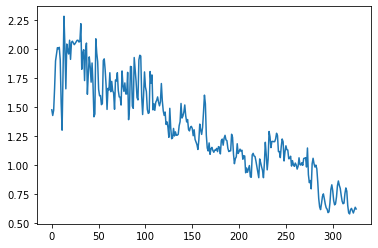

In [17]:
# Plots the predicted test values
plt.plot(y_predicted)
# Plots the true historic close values

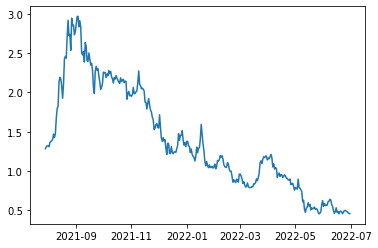

In [18]:
# Plots the true historic close values
plt.plot(df.iloc[760:]['close'])

In [19]:
y[-326]

array([1.42782998])